## Explorando F3 dataset
- tutorial dutch f3: https://github.com/microsoft/seismic-deeplearning/blob/master/examples/interpretation/notebooks/Dutch_F3_patch_model_training_and_evaluation.ipynb
- exploration edson borin: https://github.com/eborin/2024-mo436-course-work/blob/main/3-Seismic-dataloader-exploration.ipynb
- training model edson borin: https://github.com/eborin/2024-mo436-course-work/blob/main/4-Seismic-Deeplab-training.ipynb
- fine tuning example SAM: https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb

In [ ]:
# SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
# Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
# Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-91x9dmfh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-91x9dmfh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from os import path
import numpy as np
import matplotlib.pyplot as plt
import cv2
from patchify import patchify, unpatchify
import random
from datasets import Dataset
from PIL import Image

In [ ]:
# train_seismic = np.load(path.join("dataset/train/train_seismic.npy"))
# train_labels = np.load(path.join("dataset/train/train_labels.npy"))
train_seismic = np.load(path.join("/content/drive/MyDrive/UNICAMP/master tesis/sam/dataset/train/train_seismic.npy"))
train_labels = np.load(path.join("/content/drive/MyDrive/UNICAMP/master tesis/sam/dataset/train/train_labels.npy"))

print(f"number of inline slices: {train_seismic.shape[0]}")
print(f"number of crossline slices: {train_seismic.shape[1]}")
print(f"depth dimension: {train_seismic.shape[2]}")
print(len(train_seismic[0]))

number of inline slices: 401
number of crossline slices: 701
depth dimension: 255
701


In [ ]:
train_seismic.shape

(401, 701, 255)

shape original:  (401, 701, 255)
shape crossline:  (255, 701)
shape inline:  (255, 401)


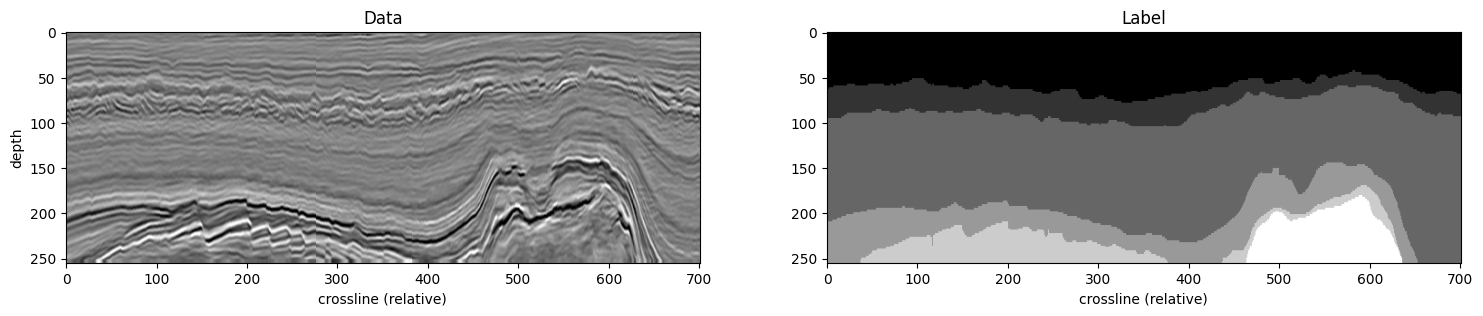

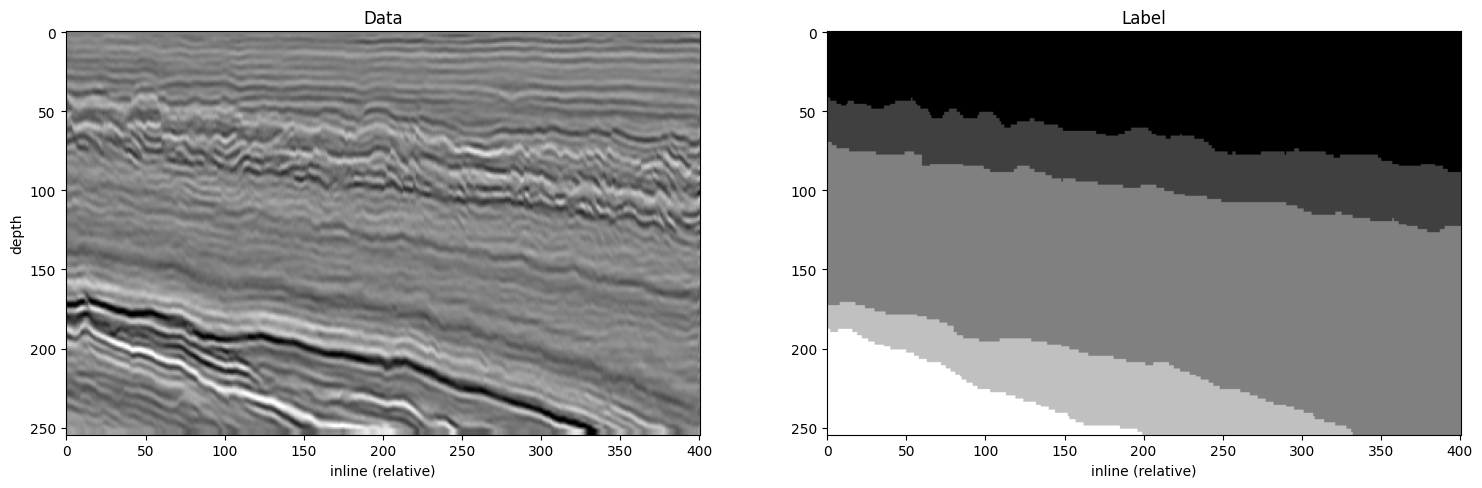

In [ ]:
def plot_aline(aline, labels, xlabel, ylabel="depth"):
    """Plot a section of the data."""
    plt.figure(figsize=(18, 6))
    # data
    plt.subplot(1, 2, 1)
    plt.imshow(aline, cmap='gray') # seismic
    plt.title("Data")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # mask
    plt.subplot(1, 2, 2)
    plt.imshow(labels, cmap='gray') # seismic
    plt.xlabel(xlabel)
    plt.title("Label")

print("shape original: ", train_seismic.shape)
idx = 100
x_in = train_seismic[idx, :, :].swapaxes(0, 1)
x_inl = train_labels[idx, :, :].swapaxes(0, 1)

image_normalized = cv2.normalize(x_in, None, 0, 255, cv2.NORM_MINMAX)
image_normalized = np.uint8(image_normalized)
# # color_image = cv2.applyColorMap(image_normalized, cv2.COLORMAP_HSV)
# cv2.imwrite("inline.png", x_in)
# cv2.imwrite("img_test.png", image_normalized)
print("shape crossline: ", x_in.shape)
plot_aline(x_in, x_inl, xlabel="crossline (relative)")

x_cr = train_seismic[:, idx, :].swapaxes(0, 1)
x_crl = train_labels[:, idx, :].swapaxes(0, 1)

print("shape inline: ", x_cr.shape)
plot_aline(x_cr, x_crl, xlabel="inline (relative)")

## Preparando dataset para inserir no modelo SAM

In [ ]:
def resize_image(image, target_shape):
  return cv2.resize(image, target_shape, interpolation=cv2.INTER_LINEAR)

def cria_patchs_sismicas_inline(images, patch_size=(256,256), step=256):
    all_img_patches = []
    for inline_idx in range(train_seismic.shape[1]): # iterando no inline
        large_image = train_seismic[:, inline_idx, :]
        target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_image_resized = resize_image(large_image, target_shape)
        patches_img = patchify(large_image_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)
    return np.array(all_img_patches)

def cria_patchs_sismicas_crossline(images, patch_size=(256,256), step=256):
    all_img_patches = []
    for crossline_idx in range(train_seismic.shape[0]): # iterando no crossline
        large_image = train_seismic[crossline_idx, :, :]
        target_shape = ((large_image.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_image.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_image_resized = resize_image(large_image, target_shape)
        patches_img = patchify(large_image_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)
    return np.array(all_img_patches)

def cria_patchs_labels_inline(images, patch_size=(256,256), step=256):
    all_mask_patches = []
    for inline_idx in range(train_labels.shape[1]): # iterando no inline
        large_mask = train_labels[:, inline_idx, :]
        target_shape = ((large_mask.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_mask.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_mask_resized = resize_image(large_mask, target_shape)
        patches_mask = patchify(large_mask_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                # single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)
    return np.array(all_mask_patches)

def cria_patchs_labels_crossline(images, patch_size=(256,256), step=256):
    all_mask_patches = []
    for crossline_idx in range(train_labels.shape[0]): # iterando no crossline
        large_mask = train_labels[crossline_idx, :, :]
        target_shape = ((large_mask.shape[1] // patch_size[1] + 1) * patch_size[1],
                        (large_mask.shape[0] // patch_size[0] + 1) * patch_size[0])
        large_mask_resized = resize_image(large_mask, target_shape)
        patches_mask = patchify(large_mask_resized, patch_size=patch_size, step=step)  #Step=256 for 256 patches means no overlap

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                # single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)
    return np.array(all_mask_patches)

images = np.concatenate((cria_patchs_sismicas_inline(train_seismic), cria_patchs_sismicas_crossline(train_seismic)), axis=0)
masks = np.concatenate((cria_patchs_labels_inline(train_labels), cria_patchs_labels_crossline(train_labels)), axis=0)

# Verificando a forma dos patches
print(f"Shape of all patches images: {images.shape}")
print(f"Shape of all patches masks: {masks.shape}")

Shape of all patches images: (2605, 256, 256)
Shape of all patches masks: (2605, 256, 256)


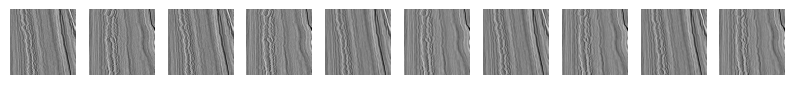

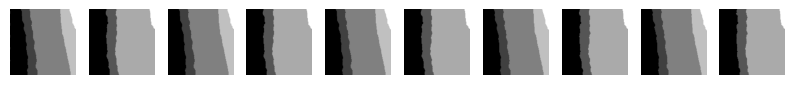

In [ ]:
# Função para plotar alguns patches
def plot_patches(patches, num_patches=10):
    plt.figure(figsize=(10, 10))
    for i in range(num_patches):
        ax = plt.subplot(1, num_patches, i + 1)
        plt.imshow(patches[i], cmap='gray')
        plt.axis("off")
    plt.show()

# Plotando os primeiros 10 patches
plot_patches(images, num_patches=10)
plot_patches(masks, num_patches=10)

Image shape: (1042, 256, 256)
Mask shape: (1042, 256, 256)


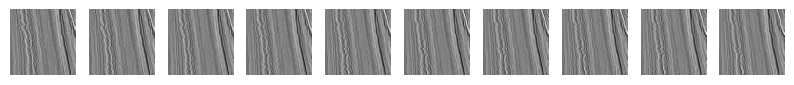

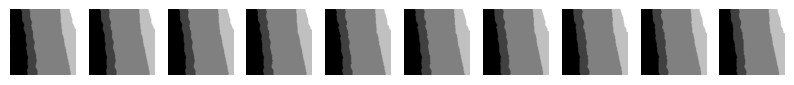

In [ ]:
# Create a list to store the indices of non-empty masks
# valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]

# criar lista com imagens que tem 5 mascaras exatas
def limite_retangulos_envolventes(image, limit=5):
  unique_values = np.unique(image)
  if len(unique_values) == limit:
    return True
  return False

valid_indices = [i for i, mask in enumerate(masks) if limite_retangulos_envolventes(mask, 5)]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)
plot_patches(filtered_images, num_patches=10)
plot_patches(filtered_masks, num_patches=10)

In [ ]:
# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 1042
})

In [ ]:
# criando detector de retangulo envolvente na imagem das mascaras
def detecta_retangulo_envolvente(image):
    unique_values = np.unique(image)
    image_with_boxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    colors = [
        (0, 0, 255),
        (0, 255, 0),
        (255, 0, 0),
        (255, 0, 255),
        (0, 255, 255),
        (255, 255, 0),
        ]
    random.shuffle(colors)

    bboxes = []
    for i, value in enumerate(unique_values):
        mask = np.uint8(image == value) * 255

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            x_max = x + w
            y_max = y + h
            bbox = [x, y, x+w, y+h]
            bboxes.append(bbox)
            # cv2.rectangle(image_with_boxes, (bbox[0], bbox[1]), (bbox[2], bbox[3]), colors[i], 2)
            if len(contours) > 1: # quebra loop pra evitar bug de shape quebrado
              break

    ## cv2.rectangle(image_with_boxes, (bboxes[-1][0], bboxes[-1][1]), (bboxes[-1][2], bboxes[-1][3]), (0, 0, 255), 2)
    # plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    # plt.title('Retângulos Envolventes')
    # plt.axis('off')
    # plt.show()

    return bboxes#[-1]

5 [[0, 0, 75, 256], [53, 0, 105, 256], [80, 0, 246, 256], [189, 0, 256, 256], [204, 0, 256, 161]]


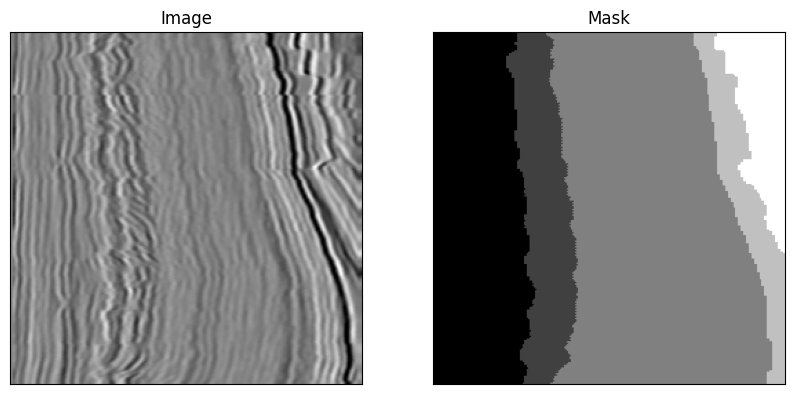

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

bbox = detecta_retangulo_envolvente(np.array(example_mask))
print(len(bbox), bbox)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    image = np.array(image)
    image = np.expand_dims(image, axis=-1)
    image = np.repeat(image, 3, axis=-1)
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    image = np.uint8(image)

    # get bounding box prompt
    prompt = detecta_retangulo_envolvente(ground_truth_mask)
    print(len(prompt))

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

5
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([5, 4])
ground_truth_mask (256, 256)


In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

5
5
pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 5, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

## Preparando modelo

In [ ]:
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      print(batch["ground_truth_mask"].shape)
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')
    torch.save(model.state_dict(), "/content/drive/MyDrive/UNICAMP/master tesis/sam/model/sam_seismic_checkpoint.pth")

  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<16:03,  1.60s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<11:45,  1.18s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:20,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<09:36,  1.04it/s]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<09:15,  1.07it/s]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:05<08:59,  1.11it/s]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:06<08:51,  1.12it/s]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:07<08:44,  1.13it/s]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:08<08:46,  1.13it/s]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:09<08:49,  1.12it/s]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:10<08:53,  1.11it/s]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:11<08:58,  1.10it/s]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:12<08:50,  1.11it/s]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:13<08:45,  1.12it/s]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:13<08:39,  1.13it/s]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:14<08:36,  1.13it/s]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:15<08:37,  1.13it/s]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:16<08:34,  1.14it/s]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:17<08:34,  1.13it/s]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:18<08:35,  1.13it/s]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:19<08:36,  1.13it/s]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:20<08:35,  1.13it/s]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:21<08:35,  1.12it/s]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:21<08:34,  1.12it/s]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:22<08:44,  1.10it/s]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:23<08:49,  1.09it/s]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:24<08:55,  1.07it/s]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:25<08:57,  1.07it/s]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:26<08:53,  1.07it/s]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:27<08:50,  1.08it/s]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:28<08:45,  1.09it/s]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:29<08:39,  1.10it/s]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:30<08:39,  1.10it/s]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:31<08:38,  1.10it/s]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:32<08:35,  1.10it/s]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:32<08:33,  1.10it/s]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:33<08:33,  1.10it/s]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:34<08:32,  1.10it/s]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:35<08:35,  1.09it/s]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:36<08:38,  1.08it/s]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:37<08:45,  1.07it/s]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:38<08:50,  1.06it/s]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:39<08:51,  1.05it/s]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:40<08:54,  1.04it/s]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:41<08:55,  1.04it/s]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:42<08:50,  1.05it/s]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:43<08:45,  1.06it/s]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:44<08:42,  1.06it/s]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:45<08:36,  1.07it/s]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:46<08:35,  1.07it/s]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:47<08:37,  1.06it/s]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:48<08:38,  1.06it/s]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:49<08:39,  1.06it/s]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:49<08:35,  1.06it/s]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:50<08:33,  1.07it/s]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [00:51<08:38,  1.05it/s]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [00:52<08:40,  1.05it/s]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [00:53<08:45,  1.03it/s]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [00:54<08:49,  1.02it/s]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [00:55<08:53,  1.02it/s]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [00:56<08:45,  1.03it/s]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [00:57<08:41,  1.03it/s]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [00:58<08:40,  1.04it/s]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [00:59<08:37,  1.04it/s]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:00<08:39,  1.03it/s]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:01<08:42,  1.03it/s]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:02<08:39,  1.03it/s]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:03<08:37,  1.03it/s]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:04<08:31,  1.04it/s]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:05<08:30,  1.04it/s]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:06<08:30,  1.04it/s]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:07<08:36,  1.03it/s]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:08<08:40,  1.02it/s]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:09<08:44,  1.01it/s]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:10<09:04,  1.03s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:11<09:36,  1.10s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:12<09:45,  1.12s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:14<10:10,  1.17s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:15<09:41,  1.11s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:16<09:22,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:17<09:12,  1.06s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:18<09:06,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:19<08:59,  1.04s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:20<08:57,  1.04s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:21<08:57,  1.04s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:22<09:03,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:23<09:06,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:24<09:13,  1.08s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:25<09:11,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:26<09:03,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:27<08:57,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:28<08:53,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:29<08:53,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:30<08:56,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:31<08:53,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:33<08:50,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:34<08:56,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:35<08:58,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:36<08:55,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:37<09:01,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:38<09:06,  1.09s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:39<09:10,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:40<09:11,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:41<09:06,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:42<09:06,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:43<09:01,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:45<08:58,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:46<08:59,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:47<08:58,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:48<08:58,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:49<08:55,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [01:50<08:54,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [01:51<08:51,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [01:52<08:55,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [01:53<09:00,  1.11s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [01:54<09:01,  1.11s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [01:56<09:02,  1.12s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [01:57<08:54,  1.11s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [01:58<08:48,  1.09s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [01:59<08:38,  1.08s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:00<08:32,  1.06s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:01<08:29,  1.06s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:02<08:29,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:03<08:25,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:04<08:23,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:05<08:20,  1.05s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:06<08:25,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:07<08:29,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:08<08:27,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:09<08:32,  1.09s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:11<08:23,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:12<08:17,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:13<08:14,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:14<08:10,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:15<08:10,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:16<08:06,  1.04s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:17<08:02,  1.04s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:18<07:57,  1.03s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:19<07:54,  1.02s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:20<07:51,  1.02s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:21<07:56,  1.03s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:22<07:56,  1.04s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:23<07:59,  1.05s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:24<08:02,  1.05s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:25<07:57,  1.04s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:26<07:51,  1.03s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:27<07:48,  1.03s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:28<07:45,  1.02s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:29<07:41,  1.02s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:30<07:40,  1.02s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:31<07:40,  1.02s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:32<07:38,  1.02s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:33<07:35,  1.02s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:34<07:34,  1.01s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:35<07:37,  1.02s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:36<07:43,  1.04s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:37<07:50,  1.06s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:39<08:01,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:40<08:05,  1.10s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:41<07:58,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:42<08:01,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:43<08:02,  1.10s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:44<07:51,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:45<07:46,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:46<07:40,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:47<07:37,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [02:48<07:34,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [02:49<07:35,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [02:50<07:36,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [02:51<07:39,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [02:52<07:44,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [02:54<07:46,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [02:55<07:47,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [02:56<07:38,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [02:57<07:32,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [02:58<07:28,  1.05s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [02:59<07:26,  1.05s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:00<07:25,  1.05s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:01<07:26,  1.06s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:02<07:23,  1.05s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:03<07:21,  1.05s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:04<07:22,  1.05s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:05<07:24,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:06<07:26,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:07<07:27,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:08<07:34,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:09<07:26,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:11<07:23,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:12<07:19,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:13<07:17,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:14<07:16,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:15<07:18,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:16<07:14,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:17<07:15,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:18<07:11,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:19<07:14,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:20<07:19,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:21<07:17,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:22<07:19,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:23<07:16,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:24<07:13,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:26<07:11,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:27<07:05,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:28<06:59,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:29<06:57,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:30<06:55,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:31<06:55,  1.05s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:32<06:56,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:33<06:53,  1.05s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:34<06:58,  1.07s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:35<07:03,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:36<07:01,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:37<07:02,  1.09s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:38<07:00,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:39<06:55,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:40<06:48,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:41<06:49,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:43<06:46,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:44<06:42,  1.05s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:45<06:39,  1.05s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:46<06:34,  1.04s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:47<06:33,  1.03s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [03:48<06:33,  1.04s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [03:49<06:39,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [03:50<06:44,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [03:51<06:43,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [03:52<06:47,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [03:53<06:46,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [03:54<06:43,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [03:55<06:37,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [03:56<06:32,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [03:57<06:28,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [03:58<06:27,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [03:59<06:28,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:00<06:24,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:02<06:24,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:03<06:22,  1.05s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:04<06:26,  1.06s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:05<06:29,  1.07s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:06<06:28,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:07<06:30,  1.08s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:08<06:33,  1.09s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:09<06:25,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:10<06:25,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:11<06:19,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:12<06:17,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:13<06:14,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:14<06:10,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:15<06:08,  1.04s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:16<06:06,  1.04s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:18<06:09,  1.05s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:19<06:16,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:20<06:16,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:21<06:17,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:22<06:21,  1.10s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:23<06:14,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:24<06:09,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:25<06:05,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:26<06:01,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:27<06:00,  1.05s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:28<06:01,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:29<05:58,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:30<05:55,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:31<05:52,  1.04s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:32<05:55,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:34<05:59,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:35<06:00,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:36<06:03,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:37<06:00,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:38<05:54,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:39<05:49,  1.05s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:40<05:46,  1.05s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:41<05:44,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:42<05:47,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:43<05:43,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:44<05:39,  1.04s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:45<05:37,  1.04s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [04:46<05:36,  1.04s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [04:47<05:35,  1.04s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [04:48<05:39,  1.05s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [04:49<05:40,  1.06s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [04:50<05:44,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [04:52<05:44,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [04:53<05:39,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [04:54<05:36,  1.06s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [04:55<05:32,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [04:56<05:30,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [04:57<05:29,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [04:58<05:26,  1.04s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [04:59<05:26,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:00<05:24,  1.04s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:01<05:22,  1.04s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:02<05:21,  1.04s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:03<05:23,  1.05s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:04<05:24,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:05<05:26,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:06<05:29,  1.08s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:07<05:24,  1.07s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:08<05:19,  1.05s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:09<05:16,  1.05s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:10<05:13,  1.04s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:11<05:12,  1.04s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:13<05:12,  1.04s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:14<05:13,  1.05s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:15<05:11,  1.05s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:16<05:09,  1.04s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:17<05:12,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:18<05:16,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:19<05:15,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:20<05:16,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:21<05:15,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:22<05:18,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:23<05:16,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:24<05:16,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:26<05:09,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:27<05:04,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:28<05:00,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:29<04:57,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:30<04:55,  1.04s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:31<04:54,  1.04s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:32<04:52,  1.04s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:33<04:52,  1.04s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:34<04:50,  1.04s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:35<04:49,  1.04s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:36<04:50,  1.05s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:37<04:53,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:38<04:56,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:39<04:56,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:40<04:53,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:41<04:50,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:42<04:48,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:43<04:46,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:44<04:44,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [05:46<04:43,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [05:47<04:40,  1.05s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [05:48<04:37,  1.04s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [05:49<04:36,  1.04s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [05:50<04:35,  1.04s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [05:51<04:39,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [05:52<04:39,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [05:53<04:39,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [05:54<04:42,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [05:55<04:41,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [05:56<04:39,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [05:57<04:38,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [05:58<04:34,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [05:59<04:31,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:00<04:29,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:02<04:29,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:03<04:25,  1.05s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:04<04:24,  1.05s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:05<04:23,  1.05s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:06<04:26,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:07<04:26,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:08<04:27,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:09<04:29,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:10<04:23,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:11<04:20,  1.07s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:12<04:19,  1.07s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:13<04:15,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:14<04:12,  1.05s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:15<04:10,  1.04s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:16<04:08,  1.04s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:17<04:07,  1.04s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:18<04:07,  1.04s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:20<04:07,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:21<04:07,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:22<04:07,  1.06s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:23<04:09,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:24<04:10,  1.08s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:25<04:05,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:26<04:03,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:27<04:02,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:28<04:01,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:29<03:58,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:30<03:57,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:31<03:55,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:32<03:53,  1.04s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:33<03:52,  1.04s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:34<03:53,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:35<03:54,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:37<03:58,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:38<03:56,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:39<03:56,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:40<03:53,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:41<03:49,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:42<03:47,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:43<03:45,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [06:44<03:43,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [06:45<03:42,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [06:46<03:43,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [06:47<03:40,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [06:48<03:38,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [06:49<03:37,  1.04s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [06:50<03:40,  1.06s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [06:51<03:39,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [06:52<03:39,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [06:54<03:41,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [06:55<03:37,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [06:56<03:34,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [06:57<03:31,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [06:58<03:30,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [06:59<03:28,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:00<03:28,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:01<03:26,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:02<03:24,  1.04s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:03<03:23,  1.04s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:04<03:24,  1.06s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:05<03:27,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:06<03:27,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:07<03:28,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:08<03:23,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:09<03:21,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:10<03:19,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:12<03:18,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:13<03:15,  1.05s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:14<03:13,  1.05s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:15<03:11,  1.04s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:16<03:10,  1.04s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:17<03:09,  1.04s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:18<03:08,  1.04s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:19<03:09,  1.05s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:20<03:09,  1.06s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:21<03:11,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:22<03:13,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:23<03:09,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:24<03:07,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:25<03:04,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:26<03:02,  1.05s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:27<03:00,  1.05s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:28<02:58,  1.04s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:29<02:57,  1.04s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:30<02:55,  1.04s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:31<02:54,  1.04s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:33<02:54,  1.04s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:34<02:57,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:35<02:56,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:36<02:58,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:37<02:57,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:38<02:55,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:39<02:52,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:40<02:50,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:41<02:49,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [07:42<02:47,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [07:43<02:45,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [07:44<02:43,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [07:45<02:41,  1.04s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [07:46<02:40,  1.04s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [07:47<02:39,  1.04s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [07:49<02:40,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [07:50<02:40,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [07:51<02:40,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [07:52<02:44,  1.10s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [07:53<02:39,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [07:54<02:38,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [07:55<02:37,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [07:56<02:36,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [07:57<02:37,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [07:58<02:35,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [07:59<02:35,  1.09s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:00<02:32,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:02<02:29,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:03<02:29,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:04<02:29,  1.09s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:05<02:28,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:06<02:27,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:07<02:27,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:08<02:24,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:09<02:22,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:10<02:19,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:11<02:18,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:12<02:17,  1.05s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:13<02:15,  1.05s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:14<02:13,  1.04s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:15<02:12,  1.04s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:16<02:11,  1.04s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:17<02:12,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:19<02:12,  1.07s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:20<02:12,  1.07s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:21<02:12,  1.09s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:22<02:11,  1.08s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:23<02:10,  1.08s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:24<02:07,  1.07s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:25<02:05,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:26<02:03,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:27<02:01,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:28<02:01,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:29<01:59,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:30<01:59,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:31<01:58,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:32<01:58,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:34<01:59,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:35<01:57,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:36<01:57,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:37<01:56,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:38<01:54,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:39<01:52,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:40<01:50,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:41<01:48,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [08:42<01:46,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [08:43<01:45,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [08:44<01:44,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [08:45<01:43,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [08:46<01:42,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [08:47<01:42,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [08:48<01:42,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [08:50<01:43,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [08:51<01:42,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [08:52<01:41,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [08:53<01:39,  1.08s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [08:54<01:37,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [08:55<01:35,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [08:56<01:34,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [08:57<01:32,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [08:58<01:31,  1.05s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [08:59<01:29,  1.04s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:00<01:28,  1.04s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:01<01:27,  1.04s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:02<01:27,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:03<01:27,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:04<01:27,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:06<01:27,  1.10s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:07<01:26,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:08<01:24,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:09<01:22,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:10<01:20,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:11<01:19,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:12<01:18,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:13<01:17,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:14<01:15,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:15<01:14,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:16<01:13,  1.05s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:17<01:13,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:18<01:13,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:19<01:12,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:20<01:12,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:22<01:10,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:23<01:09,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:24<01:07,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:25<01:05,  1.06s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:26<01:04,  1.05s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:27<01:02,  1.05s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:28<01:01,  1.05s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:29<01:00,  1.04s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:30<00:59,  1.05s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:31<00:58,  1.05s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:32<00:58,  1.06s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:33<00:57,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:34<00:57,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:35<00:56,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:36<00:55,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:37<00:53,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:38<00:51,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:40<00:50,  1.05s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [09:41<00:49,  1.05s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [09:42<00:48,  1.05s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [09:43<00:47,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [09:44<00:46,  1.05s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [09:45<00:45,  1.05s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [09:46<00:44,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [09:47<00:43,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [09:48<00:42,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [09:49<00:41,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [09:50<00:41,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [09:51<00:39,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [09:52<00:38,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [09:53<00:36,  1.05s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [09:54<00:35,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [09:55<00:34,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [09:56<00:33,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [09:57<00:32,  1.04s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [09:59<00:31,  1.04s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:00<00:30,  1.04s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:01<00:29,  1.04s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:02<00:28,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:03<00:27,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:04<00:26,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:05<00:26,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:06<00:24,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:07<00:23,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:08<00:22,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:09<00:21,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:10<00:20,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:11<00:18,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:12<00:17,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:13<00:16,  1.04s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:14<00:15,  1.04s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:15<00:14,  1.05s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:17<00:13,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:18<00:12,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:19<00:11,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:20<00:10,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:21<00:09,  1.08s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:22<00:08,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:23<00:07,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:24<00:06,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:25<00:05,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:26<00:04,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:27<00:03,  1.05s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:28<00:02,  1.05s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:29<00:01,  1.05s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:30<00:00,  1.05s/it]


EPOCH: 0
Mean loss: -5227.333325459167


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<11:20,  1.13s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:58,  1.10s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<11:03,  1.11s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<11:05,  1.11s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:51,  1.09s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:59,  1.11s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:51,  1.10s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:57,  1.11s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:46,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<10:40,  1.08s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:12<10:42,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:13<10:38,  1.08s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<10:30,  1.07s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:43,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:41,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:39,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:45,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:37,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:27,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:19,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:12,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:23<10:08,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:24<10:05,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:25<10:06,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:26<10:06,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:28<10:08,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:29<10:04,  1.05s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:08,  1.06s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:13,  1.07s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:16,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:25,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:34<10:19,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:35<10:11,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:36<10:07,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:37<10:02,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:38<09:58,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:39<09:53,  1.05s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:40<09:49,  1.04s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:41<09:47,  1.04s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:42<09:48,  1.05s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:44<09:52,  1.06s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<09:57,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:46<10:01,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:47<10:06,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:48<10:06,  1.09s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:49<10:16,  1.11s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:50<10:03,  1.09s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:51<09:59,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:52<09:51,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:53<09:49,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:54<09:45,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:55<09:41,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:56<09:41,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:57<09:39,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:59<09:35,  1.05s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [01:00<09:38,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:01<09:47,  1.08s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:02<09:46,  1.08s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:03<09:46,  1.08s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:04<09:39,  1.07s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:05<09:38,  1.07s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:06<09:31,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:07<09:27,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:08<09:23,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:09<09:24,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:10<09:21,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:11<09:21,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:12<09:16,  1.04s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:13<09:18,  1.05s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:14<09:25,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:16<09:32,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:17<09:33,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:18<09:40,  1.10s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:19<09:29,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:20<09:25,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:21<09:20,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:22<09:14,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:23<09:08,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:24<09:05,  1.04s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:25<09:02,  1.04s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:26<09:04,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:27<09:08,  1.06s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:28<09:12,  1.06s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:29<09:14,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:30<09:20,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:32<09:16,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:33<09:19,  1.09s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:34<09:11,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:35<09:04,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:36<08:58,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:37<08:54,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:38<08:52,  1.04s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:39<08:51,  1.04s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:40<08:55,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:41<08:51,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:42<08:49,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:43<08:47,  1.04s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:44<08:54,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:45<09:02,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:46<08:59,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:47<09:03,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:48<08:53,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:50<08:47,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:51<08:43,  1.05s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:52<08:44,  1.05s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:53<08:43,  1.05s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:54<08:43,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:55<08:40,  1.05s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:56<08:36,  1.05s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:57<08:39,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:58<08:43,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [01:59<08:46,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:00<08:53,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:01<08:47,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:02<08:43,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:03<08:38,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:04<08:35,  1.06s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:05<08:32,  1.06s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:06<08:27,  1.05s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:08<08:27,  1.05s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:09<08:29,  1.06s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:10<08:28,  1.06s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:11<08:24,  1.05s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:12<08:20,  1.05s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:13<08:23,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:14<08:29,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:15<08:28,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:16<08:33,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:17<08:36,  1.09s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:18<08:27,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:19<08:22,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:20<08:19,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:21<08:19,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:23<08:17,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:24<08:19,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:25<08:19,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:26<08:13,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:27<08:09,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:28<08:13,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:29<08:22,  1.09s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:30<08:18,  1.08s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:31<08:23,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:32<08:16,  1.08s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:33<08:10,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:34<08:07,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:35<08:07,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:36<08:01,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:37<08:00,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:39<08:02,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:40<08:10,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:41<08:08,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:42<08:19,  1.11s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:43<08:15,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:44<08:13,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:45<08:10,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:46<08:09,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:47<08:08,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:48<08:01,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:50<07:59,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:51<07:53,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:52<07:49,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:53<07:46,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:54<07:45,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:55<07:42,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:56<07:37,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:57<07:33,  1.04s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [02:58<07:32,  1.04s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [02:59<07:37,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:00<07:42,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:01<07:43,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:02<07:43,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:03<07:44,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:04<07:35,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:05<07:30,  1.05s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:06<07:27,  1.05s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:07<07:26,  1.05s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:09<07:25,  1.05s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:10<07:25,  1.05s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:11<07:20,  1.04s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:12<07:18,  1.04s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:13<07:17,  1.04s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:14<07:20,  1.05s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:15<07:26,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:16<07:28,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:17<07:30,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:18<07:35,  1.10s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:19<07:27,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:20<07:23,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:21<07:19,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:22<07:14,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:23<07:11,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:24<07:08,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:25<07:05,  1.04s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:26<07:04,  1.04s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:28<07:03,  1.04s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:29<07:08,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:30<07:09,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:31<07:12,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:32<07:14,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:33<07:11,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:34<07:08,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:35<07:04,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:36<07:01,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:37<06:56,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:38<06:53,  1.04s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:39<06:52,  1.04s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:40<06:50,  1.04s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:41<06:49,  1.04s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:42<06:50,  1.04s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:43<06:51,  1.05s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:44<06:57,  1.07s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:46<07:03,  1.09s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:47<07:01,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:48<07:00,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:49<06:57,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:50<06:51,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:51<06:47,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:52<06:43,  1.05s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:53<06:44,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:54<06:44,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:55<06:43,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:56<06:40,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [03:57<06:39,  1.05s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [03:58<06:44,  1.07s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [03:59<06:44,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:01<06:48,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:02<06:45,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:03<06:45,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:04<06:43,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:05<06:40,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:06<06:36,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:07<06:36,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:08<06:31,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:09<06:31,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:10<06:28,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:11<06:26,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:12<06:25,  1.06s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:13<06:30,  1.07s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:14<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:16<06:37,  1.10s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:17<06:34,  1.09s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:18<06:32,  1.09s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:19<06:25,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:20<06:20,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:21<06:18,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:22<06:15,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:23<06:16,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:24<06:16,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:25<06:12,  1.06s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:26<06:11,  1.06s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:27<06:13,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:28<06:17,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:29<06:18,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:31<06:18,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:32<06:17,  1.09s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:33<06:13,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:34<06:10,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:35<06:05,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:36<06:01,  1.05s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:37<05:58,  1.05s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:38<05:57,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:39<05:56,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:40<05:58,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:41<05:54,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:42<05:56,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:43<06:04,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:44<06:02,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:45<06:02,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:47<06:01,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:48<05:56,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:49<05:54,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:50<05:50,  1.06s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:51<05:47,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:52<05:44,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:53<05:41,  1.04s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:54<05:41,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:55<05:40,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [04:56<05:42,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [04:57<05:40,  1.05s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [04:58<05:43,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [04:59<05:46,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:00<05:46,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:01<05:49,  1.10s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:02<05:43,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:04<05:39,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:05<05:38,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:06<05:34,  1.06s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:07<05:31,  1.06s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:08<05:29,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:09<05:27,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:10<05:24,  1.04s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:11<05:25,  1.05s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:12<05:25,  1.05s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:13<05:29,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:14<05:31,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:15<05:34,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:16<05:33,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:18<05:36,  1.11s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:19<05:31,  1.10s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:20<05:31,  1.10s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:21<05:29,  1.09s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:22<05:26,  1.09s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:23<05:25,  1.09s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:24<05:19,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:25<05:17,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:26<05:16,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:27<05:15,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:28<05:15,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:29<05:18,  1.09s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:30<05:16,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:32<05:16,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:33<05:17,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:34<05:11,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:35<05:08,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:36<05:06,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:37<05:07,  1.07s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:38<05:03,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:39<05:00,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:40<05:02,  1.07s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:41<04:59,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:42<04:56,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:43<04:57,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:44<05:01,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:45<05:01,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:47<05:02,  1.09s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:48<04:58,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:49<04:53,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:50<04:52,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:51<04:50,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:52<04:46,  1.05s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:53<04:43,  1.05s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:54<04:43,  1.05s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:55<04:40,  1.04s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [05:56<04:42,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [05:57<04:40,  1.05s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [05:58<04:42,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [05:59<04:44,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:00<04:45,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:01<04:44,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:02<04:40,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:04<04:38,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:05<04:34,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:06<04:33,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:07<04:30,  1.05s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:08<04:32,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:09<04:32,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:10<04:30,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:11<04:27,  1.05s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:12<04:30,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:13<04:33,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:14<04:31,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:15<04:33,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:16<04:31,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:17<04:28,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:19<04:25,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:20<04:21,  1.06s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:21<04:18,  1.05s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:22<04:16,  1.05s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:23<04:14,  1.05s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:24<04:13,  1.05s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:25<04:13,  1.05s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:26<04:12,  1.05s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:27<04:13,  1.06s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:28<04:17,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:29<04:15,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:30<04:17,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:31<04:18,  1.10s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:32<04:13,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:33<04:11,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:35<04:07,  1.07s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:36<04:05,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:37<04:02,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:38<04:00,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:39<03:58,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:40<03:57,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:41<03:58,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:42<04:00,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:43<04:04,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:44<04:02,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:45<04:03,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:46<04:02,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:47<03:59,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:48<03:55,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:49<03:51,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:51<03:49,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:52<03:47,  1.05s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:53<03:46,  1.05s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:54<03:45,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [06:55<03:44,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [06:56<03:42,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [06:57<03:43,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [06:58<03:44,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [06:59<03:45,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:00<03:44,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:01<03:44,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:02<03:40,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:03<03:37,  1.06s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:04<03:35,  1.05s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:05<03:34,  1.05s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:06<03:33,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:08<03:31,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:09<03:29,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:10<03:27,  1.04s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:11<03:26,  1.04s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:12<03:29,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:13<03:29,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:14<03:31,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:15<03:31,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:16<03:30,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:17<03:28,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:18<03:25,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:19<03:23,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:20<03:21,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:21<03:19,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:22<03:18,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:24<03:15,  1.05s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:25<03:15,  1.05s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:26<03:14,  1.06s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:27<03:16,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:28<03:17,  1.08s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:29<03:18,  1.10s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:30<03:16,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:31<03:13,  1.08s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:32<03:11,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:33<03:09,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:34<03:06,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:35<03:04,  1.05s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:36<03:03,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:37<03:03,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:38<03:01,  1.05s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:40<03:00,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:41<02:58,  1.05s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:42<03:00,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:43<03:00,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:44<03:02,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:45<03:00,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:46<02:57,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:47<02:57,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:48<02:53,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:49<02:51,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:50<02:49,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:51<02:48,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:52<02:48,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [07:53<02:46,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [07:54<02:45,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [07:55<02:43,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [07:57<02:45,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [07:58<02:46,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [07:59<02:45,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:00<02:45,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:01<02:41,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:02<02:40,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:03<02:38,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:04<02:36,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:05<02:36,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:06<02:38,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:07<02:37,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:08<02:35,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:10<02:34,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:11<02:31,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:12<02:30,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:13<02:29,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:14<02:29,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:15<02:28,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:16<02:26,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:17<02:24,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:18<02:24,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:19<02:21,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:20<02:19,  1.05s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:21<02:17,  1.05s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:22<02:17,  1.05s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:23<02:17,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:24<02:16,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:25<02:15,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:27<02:16,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:28<02:17,  1.10s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:29<02:16,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:30<02:16,  1.10s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:31<02:14,  1.10s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:32<02:13,  1.09s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:33<02:10,  1.08s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:34<02:08,  1.07s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:35<02:07,  1.07s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:36<02:06,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:37<02:04,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:38<02:02,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:39<02:00,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:40<01:59,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:42<01:59,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:43<01:59,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:44<01:59,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:45<01:59,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:46<01:56,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:47<01:55,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:48<01:53,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:49<01:52,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:50<01:50,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:51<01:49,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:52<01:47,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [08:53<01:47,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [08:54<01:46,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [08:55<01:46,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [08:56<01:47,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [08:58<01:46,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [08:59<01:45,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:00<01:45,  1.10s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:01<01:42,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:02<01:40,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:03<01:38,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:04<01:37,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:05<01:36,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:06<01:35,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:07<01:33,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:08<01:33,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:09<01:31,  1.05s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:10<01:32,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:11<01:31,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:13<01:31,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:14<01:30,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:15<01:29,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:16<01:27,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:17<01:25,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:18<01:24,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:19<01:22,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:20<01:21,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:21<01:20,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:22<01:19,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:23<01:18,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:24<01:17,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:25<01:15,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:26<01:16,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:28<01:16,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:29<01:15,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:30<01:15,  1.11s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:31<01:13,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:32<01:11,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:33<01:09,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:34<01:08,  1.07s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:35<01:06,  1.06s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:36<01:05,  1.05s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:37<01:03,  1.05s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:38<01:03,  1.06s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:39<01:02,  1.05s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:40<01:01,  1.06s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:41<01:01,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:43<01:00,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:44<01:00,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:45<00:58,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:46<00:57,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:47<00:55,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:48<00:54,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:49<00:53,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:50<00:52,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:51<00:50,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [09:52<00:49,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [09:53<00:48,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [09:54<00:47,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [09:55<00:46,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [09:56<00:46,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [09:58<00:45,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [09:59<00:45,  1.10s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:00<00:43,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:01<00:42,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:02<00:40,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:03<00:39,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:04<00:38,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:05<00:37,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:06<00:35,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:07<00:34,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:08<00:33,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:09<00:32,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:10<00:31,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:11<00:30,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:12<00:30,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:14<00:29,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:15<00:28,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:16<00:27,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:17<00:25,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:18<00:24,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:19<00:23,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:20<00:22,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:21<00:21,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:22<00:20,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:23<00:18,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:24<00:18,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:25<00:17,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:26<00:16,  1.10s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:28<00:15,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:29<00:14,  1.11s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:30<00:13,  1.10s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:31<00:11,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:32<00:10,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:33<00:09,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:34<00:08,  1.05s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:35<00:07,  1.05s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:36<00:06,  1.05s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:37<00:05,  1.05s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:38<00:04,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:39<00:03,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:40<00:02,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:41<00:01,  1.09s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:42<00:00,  1.07s/it]


EPOCH: 1
Mean loss: -25324.254319910197


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<11:44,  1.17s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<11:14,  1.12s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:52,  1.09s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:43,  1.08s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:42,  1.08s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:33,  1.06s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:27,  1.05s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:27,  1.06s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:33,  1.07s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<10:30,  1.06s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:11<10:28,  1.06s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:12<10:38,  1.08s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<10:43,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:42,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:43,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:45,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:33,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:24,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:20,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:16,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:14,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:23<10:12,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:24<10:11,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:25<10:11,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:26<10:10,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:27<10:09,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:28<10:13,  1.07s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:16,  1.07s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:26,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:25,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:27,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:34<10:17,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:35<10:18,  1.09s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:36<10:09,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:37<10:00,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:38<09:54,  1.05s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:39<09:54,  1.05s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:40<09:51,  1.05s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:41<09:51,  1.05s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:42<09:57,  1.06s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:43<09:58,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<10:06,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:46<10:05,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:47<10:05,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:48<10:10,  1.10s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:49<10:00,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:50<09:55,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:51<09:50,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:52<09:46,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:53<09:42,  1.05s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:54<09:37,  1.05s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:55<09:34,  1.04s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:56<09:33,  1.04s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:57<09:33,  1.05s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:58<09:41,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [00:59<09:44,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:01<09:53,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:02<09:52,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:03<09:52,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:04<09:44,  1.08s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:05<09:36,  1.07s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:06<09:30,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:07<09:26,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:08<09:26,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:09<09:26,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:10<09:21,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:11<09:18,  1.04s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:12<09:16,  1.04s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:13<09:24,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:14<09:30,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:15<09:31,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:17<09:38,  1.09s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:18<09:32,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:19<09:26,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:20<09:21,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:21<09:19,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:22<09:12,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:23<09:07,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:24<09:07,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:25<09:05,  1.04s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:26<09:03,  1.04s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:27<09:04,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:28<09:05,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:29<09:13,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:30<09:18,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:31<09:16,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:32<09:20,  1.09s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:34<09:16,  1.08s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:35<09:08,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:36<09:02,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:37<08:58,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:38<08:58,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:39<08:56,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:40<08:55,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:41<08:51,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:42<08:51,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:43<08:49,  1.05s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:44<08:58,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:45<08:58,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:46<09:03,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:47<09:00,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:48<08:54,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:49<08:51,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:51<08:50,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:52<08:49,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:53<08:44,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:54<08:42,  1.05s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:55<08:46,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:56<08:43,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:57<08:40,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:58<08:37,  1.05s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [01:59<08:45,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:00<08:47,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:01<08:53,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:02<08:50,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:03<08:46,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:04<08:41,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:06<08:41,  1.08s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:07<08:35,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:08<08:34,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:09<08:32,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:10<08:31,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:11<08:29,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:12<08:27,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:13<08:23,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:14<08:35,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:15<08:37,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:16<08:40,  1.10s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:17<08:37,  1.09s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:18<08:36,  1.09s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:20<08:29,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:21<08:23,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:22<08:23,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:23<08:25,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:24<08:17,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:25<08:14,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:26<08:11,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:27<08:13,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:28<08:11,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:29<08:18,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:30<08:21,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:31<08:23,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:32<08:24,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:34<08:20,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:35<08:23,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:36<08:28,  1.12s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:37<08:26,  1.11s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:38<08:17,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:39<08:11,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:40<08:04,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:41<08:00,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:42<07:55,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:43<07:52,  1.05s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:44<07:48,  1.05s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:45<07:50,  1.05s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:46<07:53,  1.06s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:47<07:54,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:49<07:57,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:50<08:01,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:51<07:58,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:52<07:55,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:53<07:49,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:54<07:45,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:55<07:41,  1.05s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:56<07:41,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:57<07:41,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [02:58<07:43,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [02:59<07:39,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:00<07:36,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:01<07:33,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:02<07:38,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:03<07:43,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:05<07:46,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:06<07:45,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:07<07:41,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:08<07:34,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:09<07:32,  1.06s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:10<07:27,  1.06s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:11<07:24,  1.05s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:12<07:23,  1.05s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:13<07:22,  1.05s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:14<07:21,  1.05s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:15<07:21,  1.05s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:16<07:19,  1.05s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:17<07:21,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:18<07:28,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:19<07:29,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:21<07:32,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:22<07:28,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:23<07:22,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:24<07:19,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:25<07:18,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:26<07:13,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:27<07:10,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:28<07:10,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:29<07:11,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:30<07:09,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:31<07:05,  1.05s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:32<07:09,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:33<07:20,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:34<07:17,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:36<07:21,  1.10s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:37<07:16,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:38<07:13,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:39<07:05,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:40<07:03,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:41<06:59,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:42<06:57,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:43<06:57,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:44<06:54,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:45<06:52,  1.05s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:46<06:48,  1.05s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:47<06:53,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:48<06:59,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:49<06:59,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:51<07:04,  1.10s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:52<06:59,  1.09s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:53<06:54,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:54<06:51,  1.07s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:55<06:46,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:56<06:45,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:57<06:43,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [03:58<06:43,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [03:59<06:39,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:00<06:36,  1.05s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:01<06:35,  1.05s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:02<06:40,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:03<06:46,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:04<06:48,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:06<06:46,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:07<06:47,  1.10s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:08<06:42,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:09<06:37,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:10<06:32,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:11<06:30,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:12<06:32,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:13<06:26,  1.06s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:14<06:26,  1.06s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:15<06:25,  1.06s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:16<06:23,  1.06s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:17<06:23,  1.06s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:18<06:24,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:19<06:29,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:21<06:27,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:22<06:31,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:23<06:23,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:24<06:18,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:25<06:14,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:26<06:16,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:27<06:12,  1.06s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:28<06:09,  1.05s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:29<06:06,  1.05s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:30<06:04,  1.04s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:31<06:05,  1.05s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:32<06:11,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:33<06:10,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:34<06:16,  1.09s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:36<06:19,  1.10s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:37<06:18,  1.10s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:38<06:11,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:39<06:05,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:40<06:02,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:41<06:02,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:42<06:02,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:43<05:59,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:44<05:56,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:45<05:57,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:46<05:55,  1.06s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:47<05:55,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:48<06:02,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:50<06:03,  1.10s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:51<06:06,  1.11s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:52<06:02,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:53<05:58,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:54<05:54,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:55<05:48,  1.07s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:56<05:45,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [04:57<05:44,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [04:58<05:44,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [04:59<05:40,  1.06s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:00<05:39,  1.06s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:01<05:39,  1.06s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:02<05:43,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:03<05:44,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:05<05:50,  1.11s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:06<05:50,  1.11s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:07<05:49,  1.11s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:08<05:47,  1.11s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:09<05:49,  1.12s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:10<05:49,  1.12s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:11<05:39,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:12<05:33,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:13<05:28,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:14<05:24,  1.05s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:15<05:24,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:16<05:23,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:17<05:20,  1.05s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:19<05:18,  1.05s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:20<05:17,  1.05s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:21<05:18,  1.05s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:22<05:21,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:23<05:23,  1.08s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:24<05:27,  1.10s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:25<05:27,  1.10s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:26<05:22,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:27<05:19,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:28<05:14,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:29<05:10,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:30<05:09,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:31<05:08,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:32<05:09,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:34<05:05,  1.05s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:35<05:03,  1.05s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:36<05:06,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:37<05:09,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:38<05:08,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:39<05:12,  1.10s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:40<05:12,  1.10s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:41<05:07,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:42<05:04,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:43<05:00,  1.07s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:44<04:58,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:45<04:59,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:46<04:55,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:48<04:54,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:49<04:53,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:50<04:52,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:51<04:52,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:52<04:55,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:53<04:56,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:54<04:55,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:55<04:56,  1.10s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:56<04:51,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [05:57<04:47,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [05:58<04:45,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [05:59<04:44,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:00<04:42,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:01<04:39,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:03<04:37,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:04<04:39,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:05<04:36,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:06<04:40,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:07<04:42,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:08<04:43,  1.10s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:09<04:44,  1.11s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:10<04:37,  1.09s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:11<04:35,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:12<04:34,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:13<04:30,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:14<04:27,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:15<04:25,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:17<04:26,  1.06s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:18<04:24,  1.06s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:19<04:21,  1.05s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:20<04:19,  1.05s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:21<04:20,  1.06s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:22<04:23,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:23<04:23,  1.08s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:24<04:27,  1.10s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:25<04:21,  1.08s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:26<04:19,  1.08s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:27<04:15,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:28<04:13,  1.06s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:29<04:10,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:30<04:08,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:31<04:06,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:32<04:06,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:34<04:05,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:35<04:03,  1.05s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:36<04:04,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:37<04:05,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:38<04:08,  1.08s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:39<04:08,  1.08s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:40<04:09,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:41<04:03,  1.07s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:42<04:00,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:43<03:57,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:44<03:56,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:45<03:55,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:46<03:52,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:47<03:50,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:48<03:49,  1.04s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:49<03:49,  1.05s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:51<03:51,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:52<03:52,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:53<03:52,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:54<03:54,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:55<03:53,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [06:56<03:51,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [06:57<03:46,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [06:58<03:44,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [06:59<03:41,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:00<03:41,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:01<03:39,  1.05s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:02<03:37,  1.05s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:03<03:36,  1.05s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:04<03:34,  1.05s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:05<03:36,  1.06s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:07<03:38,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:08<03:38,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:09<03:40,  1.10s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:10<03:40,  1.10s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:11<03:37,  1.09s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:12<03:33,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:13<03:30,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:14<03:29,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:15<03:28,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:16<03:26,  1.06s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:17<03:23,  1.05s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:18<03:21,  1.05s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:19<03:19,  1.05s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:20<03:21,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:22<03:20,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:23<03:21,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:24<03:21,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:25<03:20,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:26<03:18,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:27<03:17,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:28<03:15,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:29<03:13,  1.06s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:30<03:11,  1.06s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:31<03:12,  1.07s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:32<03:09,  1.06s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:33<03:07,  1.05s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:34<03:05,  1.05s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:35<03:06,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:37<03:10,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:38<03:09,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:39<03:10,  1.10s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:40<03:08,  1.10s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:41<03:09,  1.11s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:42<03:06,  1.10s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:43<03:09,  1.12s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:44<03:06,  1.11s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:45<03:02,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:46<02:59,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:47<02:57,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:49<02:56,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:50<02:55,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:51<02:54,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:52<02:53,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:53<02:52,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:54<02:50,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [07:55<02:49,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [07:56<02:50,  1.09s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [07:57<02:50,  1.09s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [07:58<02:50,  1.10s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [07:59<02:47,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [08:01<02:46,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:02<02:43,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:03<02:41,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:04<02:38,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:05<02:36,  1.05s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:06<02:36,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:07<02:35,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:08<02:34,  1.05s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:09<02:32,  1.05s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:10<02:33,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:11<02:33,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:12<02:32,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:13<02:32,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:14<02:30,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:15<02:28,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:16<02:26,  1.06s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:17<02:26,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:19<02:26,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:20<02:23,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:21<02:22,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:22<02:21,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:23<02:20,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:24<02:19,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:25<02:19,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:26<02:21,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:27<02:19,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:28<02:18,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:29<02:16,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:30<02:14,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:31<02:12,  1.07s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:33<02:11,  1.07s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:34<02:09,  1.06s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:35<02:07,  1.06s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:36<02:06,  1.06s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:37<02:05,  1.06s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:38<02:04,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:39<02:02,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:40<02:02,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:41<02:03,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:42<02:03,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:43<02:03,  1.10s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:44<02:02,  1.10s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:45<02:00,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:46<01:59,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:48<01:56,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:49<01:55,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:50<01:53,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:51<01:54,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:52<01:52,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:53<01:50,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:54<01:49,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [08:55<01:49,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [08:56<01:48,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [08:57<01:49,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [08:58<01:47,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [08:59<01:45,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [09:00<01:43,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:01<01:42,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:02<01:40,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:04<01:38,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:05<01:37,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:06<01:36,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:07<01:35,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:08<01:34,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:09<01:33,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:10<01:33,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:11<01:33,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:12<01:32,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:13<01:32,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:14<01:30,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:15<01:28,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:16<01:26,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:17<01:25,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:18<01:24,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:19<01:24,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:21<01:22,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:22<01:21,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:23<01:20,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:24<01:18,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:25<01:19,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:26<01:19,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:27<01:18,  1.09s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:28<01:17,  1.09s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:29<01:15,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:30<01:13,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:31<01:11,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:32<01:10,  1.05s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:33<01:09,  1.05s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:34<01:08,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:35<01:07,  1.06s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:37<01:06,  1.06s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:38<01:05,  1.05s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:39<01:05,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:40<01:04,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:41<01:03,  1.08s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:42<01:03,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:43<01:02,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:44<01:00,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:45<00:58,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:46<00:57,  1.06s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:47<00:55,  1.06s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:48<00:54,  1.05s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:49<00:54,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:50<00:52,  1.05s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:51<00:51,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:53<00:50,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [09:54<00:50,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [09:55<00:49,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [09:56<00:49,  1.10s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [09:57<00:48,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [09:58<00:47,  1.11s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [09:59<00:45,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [10:00<00:44,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:01<00:43,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:02<00:41,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:03<00:40,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:04<00:39,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:06<00:38,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:07<00:37,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:08<00:36,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:09<00:36,  1.10s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:10<00:35,  1.10s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:11<00:34,  1.12s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:12<00:33,  1.11s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:13<00:32,  1.13s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:14<00:31,  1.12s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:16<00:29,  1.11s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:17<00:28,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:18<00:27,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:19<00:26,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:20<00:24,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:21<00:23,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:22<00:22,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:23<00:21,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:24<00:20,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:25<00:18,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:26<00:18,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:27<00:17,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:28<00:16,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:30<00:15,  1.10s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:31<00:14,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:32<00:12,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:33<00:11,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:34<00:10,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:35<00:09,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:36<00:08,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:37<00:07,  1.05s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:38<00:06,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:39<00:05,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:40<00:04,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:41<00:03,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:42<00:02,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:43<00:01,  1.09s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:44<00:00,  1.07s/it]


EPOCH: 2
Mean loss: -70365.58529186566


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<10:46,  1.08s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:29,  1.05s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:33,  1.06s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:25,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:23,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:19,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:19,  1.04s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:20,  1.04s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:25,  1.05s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<10:41,  1.08s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:11<10:51,  1.10s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:12<10:58,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<11:06,  1.13s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:51,  1.11s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:41,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:29,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:22,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:20,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:17,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:15,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:10,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:23<10:06,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:24<10:09,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:25<10:16,  1.07s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:26<10:22,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:27<10:28,  1.09s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:28<10:26,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:19,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:16,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:08,  1.06s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:02,  1.06s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:34<09:58,  1.05s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:35<09:59,  1.05s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:36<09:59,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:37<10:03,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:38<09:59,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:39<09:59,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:40<10:08,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:41<10:10,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:42<10:20,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:43<10:17,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<10:11,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:46<10:00,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:47<09:53,  1.06s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:48<09:50,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:49<09:47,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:50<09:45,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:51<09:51,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:52<09:44,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:53<09:41,  1.05s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:54<09:40,  1.05s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:55<09:47,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:56<09:49,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:57<09:54,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:58<10:01,  1.10s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [00:59<09:55,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:01<09:45,  1.08s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:02<09:37,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:03<09:32,  1.05s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:04<09:29,  1.05s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:05<09:27,  1.05s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:06<09:25,  1.05s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:07<09:28,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:08<09:24,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:09<09:27,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:10<09:31,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:11<09:35,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:12<09:36,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:13<09:43,  1.10s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:14<09:35,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:15<09:32,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:16<09:28,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:18<09:26,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:19<09:20,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:20<09:16,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:21<09:14,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:22<09:16,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:23<09:11,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:24<09:17,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:25<09:25,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:26<09:24,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:27<09:26,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:28<09:28,  1.10s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:29<09:22,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:30<09:17,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:31<09:10,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:33<09:04,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:34<08:59,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:35<08:56,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:36<08:57,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:37<08:58,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:38<08:56,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:39<08:58,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:40<09:02,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:41<09:06,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:42<09:03,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:43<08:59,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:44<08:56,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:45<08:50,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:46<08:47,  1.05s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:47<08:43,  1.05s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:48<08:40,  1.04s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:49<08:41,  1.05s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:50<08:46,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:52<08:47,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:53<08:46,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:54<08:52,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:55<08:53,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:56<08:54,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:57<08:57,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:58<08:58,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [01:59<09:04,  1.11s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:00<09:02,  1.11s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:02<09:06,  1.12s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:03<08:51,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:04<08:45,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:05<08:43,  1.08s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:06<08:35,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:07<08:30,  1.06s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:08<08:28,  1.06s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:09<08:26,  1.05s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:10<08:24,  1.05s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:11<08:23,  1.05s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:12<08:23,  1.05s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:13<08:28,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:14<08:30,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:15<08:29,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:16<08:32,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:17<08:28,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:18<08:23,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:20<08:19,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:21<08:18,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:22<08:16,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:23<08:12,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:24<08:10,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:25<08:07,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:26<08:08,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:27<08:06,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:28<08:11,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:29<08:14,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:30<08:28,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:31<08:27,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:32<08:22,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:33<08:15,  1.08s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:34<08:07,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:36<08:09,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:37<08:03,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:38<08:00,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:39<07:56,  1.05s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:40<07:53,  1.05s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:41<07:50,  1.04s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:42<07:49,  1.04s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:43<07:58,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:44<08:00,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:45<08:04,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:46<08:04,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:47<07:58,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:48<07:59,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:49<07:53,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:50<07:48,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:51<07:44,  1.05s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:53<07:43,  1.05s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:54<07:45,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:55<07:41,  1.05s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:56<07:38,  1.05s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:57<07:40,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [02:58<07:48,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [02:59<07:47,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:00<07:48,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:01<07:54,  1.10s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:02<07:44,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:03<07:40,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:04<07:36,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:05<07:35,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:06<07:32,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:07<07:30,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:09<07:33,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:10<07:31,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:11<07:27,  1.06s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:12<07:31,  1.07s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:13<07:34,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:14<07:33,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:15<07:36,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:16<07:32,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:17<07:30,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:18<07:26,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:19<07:21,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:20<07:16,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:21<07:14,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:22<07:12,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:23<07:13,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:25<07:12,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:26<07:09,  1.05s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:27<07:13,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:28<07:15,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:29<07:18,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:30<07:20,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:31<07:17,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:32<07:12,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:33<07:07,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:34<07:05,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:35<07:04,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:36<07:03,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:37<07:00,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:38<06:57,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:39<06:57,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:41<06:59,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:42<07:03,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:43<07:05,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:44<07:09,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:45<07:05,  1.09s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:46<07:07,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:47<07:00,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:48<06:56,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:49<06:55,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:50<06:51,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:51<06:47,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:52<06:45,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:53<06:46,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:55<06:45,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:56<06:41,  1.05s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:57<06:41,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [03:58<06:46,  1.07s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [03:59<06:49,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:00<06:50,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:01<06:49,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:02<06:42,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:03<06:40,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:04<06:38,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:05<06:40,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:06<06:36,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:07<06:36,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:08<06:37,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:10<06:33,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:11<06:29,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:12<06:36,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:13<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:14<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:15<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:16<06:30,  1.08s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:17<06:25,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:18<06:23,  1.06s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:19<06:22,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:20<06:18,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:21<06:14,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:22<06:12,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:23<06:12,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:24<06:18,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:26<06:20,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:27<06:27,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:28<06:24,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:29<06:27,  1.11s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:30<06:26,  1.11s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:31<06:28,  1.12s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:32<06:24,  1.11s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:33<06:17,  1.09s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:34<06:10,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:35<06:05,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:36<06:01,  1.05s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:37<05:58,  1.05s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:39<05:56,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:40<05:58,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:41<05:55,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:42<05:56,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:43<05:53,  1.05s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:44<05:58,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:45<06:02,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:46<06:02,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:47<06:06,  1.10s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:48<06:02,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:49<05:58,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:50<05:54,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:51<05:50,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:52<05:46,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:54<05:46,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:55<05:45,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:56<05:42,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [04:57<05:39,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [04:58<05:37,  1.04s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [04:59<05:41,  1.06s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:00<05:45,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:01<05:46,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:02<05:54,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:03<05:45,  1.09s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:04<05:41,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:05<05:38,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:06<05:33,  1.06s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:07<05:30,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:08<05:28,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:09<05:26,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:11<05:26,  1.05s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:12<05:27,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:13<05:29,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:14<05:33,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:15<05:30,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:16<05:32,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:17<05:34,  1.10s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:18<05:29,  1.08s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:19<05:27,  1.08s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:20<05:23,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:21<05:21,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:22<05:17,  1.06s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:23<05:14,  1.05s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:24<05:12,  1.05s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:25<05:11,  1.05s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:27<05:12,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:28<05:15,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:29<05:19,  1.09s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:30<05:19,  1.09s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:31<05:19,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:32<05:16,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:33<05:13,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:34<05:11,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:35<05:09,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:36<05:04,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:37<05:01,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:38<04:58,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:39<04:59,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:41<04:58,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:42<04:56,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:43<04:55,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:44<04:57,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:45<05:02,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:46<05:02,  1.09s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:47<05:04,  1.10s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:48<04:58,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:49<04:57,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:50<04:55,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:51<04:51,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:52<04:49,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:53<04:49,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:54<04:47,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:56<04:44,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [05:57<04:41,  1.05s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [05:58<04:40,  1.05s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [05:59<04:42,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:00<04:46,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:01<04:46,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:02<04:45,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:03<04:41,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:04<04:39,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:05<04:38,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:06<04:35,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:07<04:32,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:08<04:31,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:09<04:30,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:10<04:29,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:11<04:28,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:13<04:29,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:14<04:34,  1.09s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:15<04:32,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:16<04:33,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:17<04:30,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:18<04:26,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:19<04:24,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:20<04:23,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:21<04:20,  1.06s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:22<04:18,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:23<04:17,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:24<04:18,  1.07s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:25<04:16,  1.06s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:26<04:13,  1.05s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:28<04:10,  1.05s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:29<04:11,  1.06s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:30<04:15,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:31<04:13,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:32<04:13,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:33<04:09,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:34<04:06,  1.06s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:35<04:04,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:36<04:02,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:37<04:02,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:38<04:00,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:39<03:59,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:40<03:58,  1.05s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:41<03:56,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:42<03:57,  1.05s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:43<04:02,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:45<04:00,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:46<04:00,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:47<03:59,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:48<03:57,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:49<03:54,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:50<03:51,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:51<03:49,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:52<03:48,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:53<03:50,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:54<03:50,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [06:55<03:50,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [06:56<03:50,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [06:57<03:47,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [06:59<03:46,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:00<03:47,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:01<03:45,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:02<03:46,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:03<03:42,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:04<03:38,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:05<03:36,  1.06s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:06<03:34,  1.06s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:07<03:35,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:08<03:32,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:09<03:32,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:10<03:32,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:11<03:30,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:12<03:27,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:13<03:29,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:15<03:31,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:16<03:29,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:17<03:31,  1.10s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:18<03:26,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:19<03:24,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:20<03:23,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:21<03:21,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:22<03:19,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:23<03:17,  1.05s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:24<03:15,  1.05s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:25<03:14,  1.05s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:26<03:13,  1.05s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:27<03:16,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:28<03:15,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:30<03:17,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:31<03:16,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:32<03:16,  1.10s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:33<03:13,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:34<03:11,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:35<03:09,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:36<03:06,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:37<03:03,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:38<03:02,  1.05s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:39<03:01,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:40<03:01,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:41<02:59,  1.05s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:42<02:58,  1.05s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:43<03:01,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:45<03:00,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:46<02:59,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:47<02:58,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:48<02:55,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:49<02:52,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:50<02:51,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:51<02:50,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:52<02:49,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:53<02:47,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [07:54<02:45,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [07:55<02:45,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [07:56<02:43,  1.05s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [07:57<02:44,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [07:58<02:45,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [07:59<02:46,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:01<02:44,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:02<02:43,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:03<02:42,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:04<02:39,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:05<02:37,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:06<02:35,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:07<02:34,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:08<02:33,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:09<02:31,  1.05s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:10<02:30,  1.05s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:11<02:30,  1.06s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:12<02:29,  1.06s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:13<02:29,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:14<02:29,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:15<02:29,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:17<02:28,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:18<02:26,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:19<02:24,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:20<02:22,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:21<02:20,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:22<02:19,  1.05s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:23<02:18,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:24<02:17,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:25<02:16,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:26<02:14,  1.05s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:27<02:13,  1.05s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:28<02:14,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:29<02:13,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:30<02:12,  1.07s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:31<02:12,  1.08s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:33<02:11,  1.08s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:34<02:09,  1.07s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:35<02:07,  1.07s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:36<02:06,  1.07s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:37<02:04,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:38<02:02,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:39<02:01,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:40<02:00,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:41<01:59,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:42<01:58,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:43<01:59,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:44<02:00,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:45<01:59,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:46<01:57,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:47<01:58,  1.10s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:48<01:55,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:50<01:53,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:51<01:51,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:52<01:51,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:53<01:48,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [08:54<01:47,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [08:55<01:46,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [08:56<01:44,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [08:57<01:45,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [08:58<01:43,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [08:59<01:43,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:00<01:43,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:01<01:42,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:02<01:42,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:03<01:41,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:04<01:38,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:06<01:37,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:07<01:36,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:08<01:34,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:09<01:33,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:10<01:31,  1.05s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:11<01:30,  1.05s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:12<01:29,  1.05s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:13<01:28,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:14<01:29,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:15<01:29,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:16<01:27,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:17<01:27,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:18<01:25,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:19<01:23,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:20<01:21,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:21<01:19,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:23<01:18,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:24<01:17,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:25<01:17,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:26<01:15,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:27<01:14,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:28<01:13,  1.05s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:29<01:13,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:30<01:13,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:31<01:13,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:32<01:12,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:33<01:11,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:34<01:09,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:35<01:07,  1.07s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:37<01:06,  1.07s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:38<01:05,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:39<01:04,  1.08s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:40<01:03,  1.08s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:41<01:03,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:42<01:02,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:43<01:02,  1.11s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:44<01:00,  1.11s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:45<01:00,  1.11s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:46<00:58,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:48<00:57,  1.11s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:49<00:55,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:50<00:53,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:51<00:52,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:52<00:51,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [09:53<00:49,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [09:54<00:48,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [09:55<00:47,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [09:56<00:46,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [09:57<00:45,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [09:58<00:44,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [09:59<00:44,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:00<00:43,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:01<00:42,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:03<00:41,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:04<00:40,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:05<00:38,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:06<00:37,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:07<00:36,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:08<00:35,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:09<00:34,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:10<00:32,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:11<00:31,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:12<00:30,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:13<00:29,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:14<00:29,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:15<00:28,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:16<00:27,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:18<00:26,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:19<00:24,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:20<00:23,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:21<00:22,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:22<00:21,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:23<00:20,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:24<00:19,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:25<00:17,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:26<00:16,  1.05s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:27<00:15,  1.05s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:28<00:14,  1.06s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:29<00:13,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:30<00:12,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:31<00:12,  1.10s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:33<00:10,  1.10s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:34<00:09,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:35<00:08,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:36<00:07,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:37<00:06,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:38<00:05,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:39<00:04,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:40<00:03,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:41<00:02,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:42<00:01,  1.06s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:43<00:00,  1.07s/it]


EPOCH: 3
Mean loss: -159969.3083471761


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<10:54,  1.09s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:39,  1.07s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:22,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:20,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:18,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:20,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:21,  1.05s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:23,  1.05s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:34,  1.07s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<10:48,  1.10s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:11<10:59,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:12<10:59,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<10:55,  1.11s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:41,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:32,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:32,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:32,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:24,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:23,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:22,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:25,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:23<10:29,  1.09s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:24<10:38,  1.10s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:25<10:35,  1.10s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:27<10:40,  1.11s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:28<10:37,  1.11s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:29<10:35,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:24,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:23,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:24,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:18,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:34<10:16,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:35<10:13,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:36<10:06,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:37<10:04,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:38<10:15,  1.09s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:40<10:15,  1.09s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:41<10:18,  1.10s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:42<10:17,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:43<10:18,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:44<10:05,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<10:00,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:46<09:53,  1.06s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:47<09:52,  1.06s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:48<09:53,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:49<09:50,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:50<09:45,  1.05s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:51<09:44,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:52<09:41,  1.05s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:53<09:42,  1.05s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:54<09:48,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:56<09:54,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:57<09:57,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:58<09:56,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:59<09:52,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [01:00<09:43,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:01<09:37,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:02<09:35,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:03<09:33,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:04<09:34,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:05<09:30,  1.05s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:06<09:30,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:07<09:28,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:08<09:28,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:09<09:32,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:10<09:34,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:12<09:37,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:13<09:44,  1.09s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:14<09:38,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:15<09:32,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:16<09:27,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:17<09:23,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:18<09:22,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:19<09:26,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:20<09:27,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:21<09:32,  1.09s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:22<09:23,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:23<09:17,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:24<09:22,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:26<09:24,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:27<09:21,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:28<09:23,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:29<09:26,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:30<09:18,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:31<09:13,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:32<09:09,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:33<09:10,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:34<09:03,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:35<08:59,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:36<08:56,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:37<08:56,  1.05s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:38<08:58,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:39<09:00,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:40<09:09,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:42<09:12,  1.09s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:43<09:10,  1.09s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:44<09:15,  1.10s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:45<09:07,  1.09s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:46<09:04,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:47<09:04,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:48<08:58,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:49<08:57,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:50<08:51,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:51<08:49,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:52<08:48,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:53<08:52,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:55<08:54,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:56<08:52,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:57<08:58,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:58<08:55,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:59<09:00,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [02:00<08:52,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:01<08:45,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:02<08:46,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:03<08:40,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:04<08:39,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:05<08:38,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:06<08:41,  1.08s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:07<08:36,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:08<08:34,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:10<08:35,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:11<08:44,  1.09s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:12<08:40,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:13<08:44,  1.10s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:14<08:35,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:15<08:32,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:16<08:29,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:17<08:25,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:18<08:20,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:19<08:15,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:20<08:14,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:21<08:12,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:22<08:13,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:23<08:10,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:24<08:15,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:26<08:23,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:27<08:22,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:28<08:24,  1.09s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:29<08:21,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:30<08:14,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:31<08:11,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:32<08:10,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:33<08:06,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:34<08:02,  1.05s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:35<07:58,  1.05s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:36<07:56,  1.04s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:37<07:53,  1.04s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:38<07:54,  1.05s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:39<08:00,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:40<08:04,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:42<08:09,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:43<08:07,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:44<08:07,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:45<08:06,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:46<07:57,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:47<07:52,  1.06s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:48<07:49,  1.06s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:49<07:48,  1.05s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:50<07:48,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:51<07:44,  1.05s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:52<07:41,  1.05s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:53<07:41,  1.05s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:54<07:45,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:55<07:51,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:56<07:52,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:58<07:55,  1.09s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [02:59<07:54,  1.09s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [03:00<07:48,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:01<07:46,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:02<07:39,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:03<07:37,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:04<07:37,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:05<07:37,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:06<07:34,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:07<07:30,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:08<07:29,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:09<07:34,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:10<07:33,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:11<07:37,  1.08s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:13<07:44,  1.10s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:14<07:40,  1.09s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:15<07:39,  1.09s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:16<07:33,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:17<07:32,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:18<07:29,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:19<07:25,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:20<07:20,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:21<07:20,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:22<07:19,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:23<07:18,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:24<07:18,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:26<07:27,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:27<07:26,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:28<07:27,  1.10s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:29<07:19,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:30<07:16,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:31<07:15,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:32<07:14,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:33<07:08,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:34<07:07,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:35<07:05,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:36<07:06,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:37<07:01,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:38<06:57,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:39<07:02,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:41<07:11,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:42<07:07,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:43<07:12,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:44<07:10,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:45<07:13,  1.11s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:46<07:12,  1.11s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:47<07:15,  1.12s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:48<07:11,  1.11s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:49<07:06,  1.10s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:50<06:57,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:51<06:53,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:52<06:49,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:54<06:49,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:55<06:51,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:56<06:53,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:57<06:57,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:58<06:55,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [03:59<06:51,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [04:00<06:49,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:01<06:45,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:02<06:43,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:03<06:41,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:04<06:39,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:05<06:35,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:06<06:33,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:08<06:34,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:09<06:34,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:10<06:37,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:11<06:42,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:12<06:42,  1.10s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:13<06:42,  1.10s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:14<06:36,  1.09s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:15<06:36,  1.09s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:16<06:29,  1.07s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:17<06:28,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:18<06:23,  1.06s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:19<06:22,  1.06s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:20<06:22,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:22<06:20,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:23<06:16,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:24<06:21,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:25<06:26,  1.09s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:26<06:28,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:27<06:27,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:28<06:27,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:29<06:25,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:30<06:17,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:31<06:15,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:32<06:13,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:34<06:13,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:35<06:08,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:36<06:06,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:37<06:08,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:38<06:03,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:39<06:05,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:40<06:10,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:41<06:08,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:42<06:09,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:43<06:13,  1.10s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:44<06:07,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:45<06:03,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:46<05:58,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:47<05:53,  1.06s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:48<05:49,  1.05s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:50<05:49,  1.05s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:51<05:49,  1.06s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:52<05:51,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:53<05:47,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:54<05:52,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:55<05:54,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:56<05:54,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:57<05:57,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [04:58<05:53,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [04:59<05:51,  1.09s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [05:00<05:46,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:01<05:43,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:02<05:41,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:04<05:41,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:05<05:40,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:06<05:36,  1.06s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:07<05:33,  1.05s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:08<05:36,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:09<05:38,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:10<05:38,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:11<05:42,  1.10s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:12<05:39,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:13<05:41,  1.10s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:14<05:34,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:15<05:29,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:17<05:29,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:18<05:26,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:19<05:22,  1.06s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:20<05:20,  1.06s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:21<05:19,  1.05s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:22<05:21,  1.06s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:23<05:17,  1.06s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:24<05:16,  1.06s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:25<05:19,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:26<05:21,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:27<05:21,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:28<05:23,  1.09s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:29<05:17,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:30<05:12,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:31<05:10,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:32<05:11,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:34<05:10,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:35<05:08,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:36<05:04,  1.05s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:37<05:03,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:38<05:04,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:39<05:03,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:40<05:04,  1.07s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:41<05:05,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:42<05:06,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:43<05:08,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:44<05:05,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:45<05:02,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:46<04:59,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:47<04:57,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:49<04:53,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:50<04:49,  1.05s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:51<04:47,  1.05s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:52<04:46,  1.05s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:53<04:45,  1.05s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:54<04:44,  1.05s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:55<04:50,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:56<04:50,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:57<04:53,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [05:58<04:51,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [05:59<04:49,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [06:00<04:45,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:01<04:42,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:02<04:41,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:03<04:39,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:05<04:39,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:06<04:35,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:07<04:33,  1.05s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:08<04:32,  1.05s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:09<04:35,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:10<04:35,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:11<04:40,  1.10s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:12<04:38,  1.09s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:13<04:41,  1.11s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:14<04:39,  1.11s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:15<04:40,  1.11s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:17<04:41,  1.12s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:18<04:42,  1.13s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:19<04:35,  1.11s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:20<04:33,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:21<04:28,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:22<04:24,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:23<04:21,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:24<04:21,  1.07s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:25<04:17,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:26<04:16,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:27<04:15,  1.06s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:28<04:16,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:29<04:16,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:31<04:17,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:32<04:19,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:33<04:14,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:34<04:13,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:35<04:09,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:36<04:07,  1.06s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:37<04:05,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:38<04:04,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:39<04:03,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:40<04:02,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:41<04:01,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:42<04:00,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:43<04:04,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:44<04:06,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:46<04:06,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:47<04:05,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:48<04:04,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:49<03:58,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:50<03:54,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:51<03:51,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:52<03:50,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:53<03:51,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:54<03:49,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:55<03:47,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:56<03:45,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [06:57<03:49,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [06:58<03:48,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [06:59<03:49,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [07:01<03:50,  1.10s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:02<03:47,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:03<03:46,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:04<03:43,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:05<03:41,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:06<03:41,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:07<03:37,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:08<03:34,  1.06s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:09<03:33,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:10<03:32,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:11<03:31,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:12<03:29,  1.05s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:13<03:29,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:14<03:32,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:16<03:30,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:17<03:31,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:18<03:29,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:19<03:26,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:20<03:24,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:21<03:24,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:22<03:23,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:23<03:21,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:24<03:19,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:25<03:19,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:26<03:19,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:27<03:16,  1.06s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:28<03:17,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:30<03:19,  1.09s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:31<03:17,  1.08s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:32<03:16,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:33<03:15,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:34<03:14,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:35<03:12,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:36<03:09,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:37<03:06,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:38<03:05,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:39<03:04,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:40<03:04,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:41<03:03,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:42<03:03,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:43<03:04,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:45<03:03,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:46<03:04,  1.10s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:47<03:02,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:48<03:00,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:49<02:57,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:50<02:55,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:51<02:55,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:52<02:55,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:53<02:51,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:54<02:50,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:55<02:49,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [07:56<02:47,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [07:57<02:48,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [07:59<02:48,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [08:00<02:47,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [08:01<02:47,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [08:02<02:46,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:03<02:42,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:04<02:40,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:05<02:38,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:06<02:38,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:07<02:37,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:08<02:35,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:09<02:33,  1.05s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:10<02:32,  1.05s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:11<02:32,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:12<02:32,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:13<02:32,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:15<02:32,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:16<02:31,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:17<02:30,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:18<02:28,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:19<02:25,  1.06s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:20<02:24,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:21<02:22,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:22<02:22,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:23<02:21,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:24<02:20,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:25<02:19,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:26<02:17,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:27<02:19,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:28<02:18,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:30<02:18,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:31<02:17,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:32<02:17,  1.10s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:33<02:15,  1.09s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:34<02:15,  1.10s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:35<02:13,  1.09s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:36<02:12,  1.09s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:37<02:11,  1.10s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:38<02:09,  1.09s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:39<02:06,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:40<02:05,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:41<02:03,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:43<02:03,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:44<02:04,  1.10s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:45<02:02,  1.09s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:46<02:01,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:47<02:01,  1.10s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:48<01:59,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:49<01:58,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:50<01:55,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:51<01:54,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:52<01:52,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:53<01:52,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:54<01:51,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:55<01:49,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [08:57<01:47,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [08:58<01:48,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [08:59<01:48,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [09:00<01:47,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [09:01<01:46,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [09:02<01:46,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:03<01:44,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:04<01:42,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:05<01:40,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:06<01:39,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:07<01:38,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:08<01:36,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:10<01:35,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:11<01:34,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:12<01:34,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:13<01:34,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:14<01:34,  1.10s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:15<01:33,  1.10s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:16<01:32,  1.10s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:17<01:30,  1.10s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:18<01:29,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:19<01:27,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:20<01:25,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:21<01:23,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:22<01:22,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:23<01:21,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:25<01:20,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:26<01:18,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:27<01:17,  1.05s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:28<01:17,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:29<01:17,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:30<01:16,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:31<01:16,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:32<01:15,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:33<01:13,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:34<01:11,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:35<01:10,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:36<01:08,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:37<01:07,  1.05s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:38<01:06,  1.06s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:40<01:05,  1.06s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:41<01:04,  1.05s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:42<01:02,  1.05s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:43<01:03,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:44<01:03,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:45<01:01,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:46<01:01,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:47<00:59,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:48<00:57,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:49<00:56,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:50<00:55,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:51<00:54,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:52<00:53,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:53<00:52,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:55<00:50,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [09:56<00:49,  1.05s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [09:57<00:48,  1.05s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [09:58<00:47,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [09:59<00:47,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [10:00<00:46,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [10:01<00:46,  1.10s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [10:02<00:44,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:03<00:43,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:04<00:41,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:05<00:40,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:06<00:39,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:07<00:38,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:08<00:37,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:09<00:35,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:11<00:34,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:12<00:33,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:13<00:33,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:14<00:32,  1.09s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:15<00:31,  1.09s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:16<00:30,  1.10s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:17<00:29,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:18<00:28,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:19<00:26,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:20<00:25,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:21<00:24,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:22<00:23,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:23<00:22,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:24<00:21,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:26<00:20,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:27<00:19,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:28<00:18,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:29<00:17,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:30<00:16,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:31<00:15,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:32<00:14,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:33<00:12,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:34<00:11,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:35<00:10,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:36<00:09,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:37<00:08,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:38<00:07,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:39<00:06,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:41<00:05,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:42<00:04,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:43<00:03,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:44<00:02,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:45<00:01,  1.10s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:45<00:00,  1.07s/it]


EPOCH: 4
Mean loss: -314248.5520660299


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<11:13,  1.12s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:41,  1.07s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:29,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:27,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:27,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:30,  1.06s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:34,  1.07s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:51,  1.10s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<11:24,  1.15s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<11:11,  1.13s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:12<11:14,  1.14s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:13<11:06,  1.13s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<11:03,  1.13s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:59,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:52,  1.11s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:47,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:38,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:27,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:22,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:16,  1.06s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:16,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:23<10:16,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:25<10:12,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:26<10:07,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:27<10:07,  1.05s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:28<10:11,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:29<10:24,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:23,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:31,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:31,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:21,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:34<10:16,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:35<10:10,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:36<10:14,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:37<10:08,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:39<10:01,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:40<09:58,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:41<10:01,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:42<09:58,  1.06s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:43<09:59,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:44<10:05,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<10:06,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:46<10:05,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:47<10:10,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:48<09:59,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:49<09:57,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:50<09:53,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:51<09:51,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:52<09:45,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:53<09:41,  1.05s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:55<09:41,  1.05s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:56<09:40,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:57<09:44,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:58<09:49,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:59<09:52,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [01:00<09:51,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:01<09:56,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:02<10:00,  1.10s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:03<09:54,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:04<09:52,  1.09s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:05<09:42,  1.08s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:06<09:40,  1.07s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:08<09:38,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:09<09:30,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:10<09:28,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:11<09:24,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:12<09:22,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:13<09:26,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:14<09:28,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:15<09:29,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:16<09:31,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:17<09:32,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:18<09:30,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:19<09:27,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:20<09:23,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:21<09:20,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:22<09:19,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:24<09:17,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:25<09:14,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:26<09:09,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:27<09:08,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:28<09:10,  1.06s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:29<09:15,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:30<09:20,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:31<09:25,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:32<09:26,  1.10s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:33<09:21,  1.09s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:34<09:12,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:35<09:07,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:36<09:02,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:37<09:01,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:39<09:01,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:40<09:00,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:41<09:00,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:42<08:58,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:43<08:58,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:44<09:02,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:45<09:04,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:46<09:12,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:47<09:12,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:48<09:03,  1.09s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:49<08:55,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:50<08:51,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:51<08:50,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:52<08:50,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:54<08:44,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:55<08:43,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:56<08:40,  1.05s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:57<08:39,  1.05s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:58<08:43,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:59<08:44,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [02:00<08:46,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:01<08:54,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:02<08:53,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:03<08:57,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:04<08:49,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:05<08:45,  1.08s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:06<08:39,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:08<08:36,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:09<08:34,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:10<08:35,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:11<08:31,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:12<08:28,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:13<08:27,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:14<08:33,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:15<08:32,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:16<08:36,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:17<08:35,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:18<08:40,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:19<08:30,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:20<08:25,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:21<08:19,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:23<08:17,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:24<08:15,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:25<08:11,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:26<08:10,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:27<08:07,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:28<08:07,  1.05s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:29<08:13,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:30<08:16,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:31<08:23,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:32<08:21,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:33<08:21,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:34<08:21,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:36<08:22,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:37<08:23,  1.11s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:38<08:23,  1.11s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:39<08:17,  1.10s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:40<08:08,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:41<08:03,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:42<07:59,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:43<07:58,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:44<08:00,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:45<08:00,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:46<08:02,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:47<08:08,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:48<08:01,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:50<07:59,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:51<07:54,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:52<07:51,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:53<07:50,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:54<07:50,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:55<07:49,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:56<07:44,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:57<07:43,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:58<07:46,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [02:59<07:46,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [03:00<07:50,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:01<07:56,  1.10s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:02<07:54,  1.10s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:04<07:54,  1.10s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:05<07:44,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:06<07:44,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:07<07:41,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:08<07:38,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:09<07:36,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:10<07:33,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:11<07:38,  1.08s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:12<07:31,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:13<07:30,  1.07s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:14<07:32,  1.07s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:15<07:31,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:16<07:35,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:18<07:37,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:19<07:33,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:20<07:30,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:21<07:25,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:22<07:21,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:23<07:21,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:24<07:23,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:25<07:17,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:26<07:16,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:27<07:14,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:28<07:12,  1.06s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:29<07:15,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:30<07:16,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:31<07:24,  1.10s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:33<07:21,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:34<07:15,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:35<07:11,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:36<07:08,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:37<07:07,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:38<07:05,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:39<07:01,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:40<07:00,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:41<06:58,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:42<06:58,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:43<07:03,  1.07s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:44<07:03,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:45<07:04,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:47<07:08,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:48<07:03,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:49<06:56,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:50<06:52,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:51<06:50,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:52<06:48,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:53<06:48,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:54<06:45,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:55<06:45,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:56<06:43,  1.06s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:57<06:41,  1.05s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:58<06:46,  1.07s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [03:59<06:47,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [04:00<06:53,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:01<06:56,  1.10s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:03<06:51,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:04<06:45,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:05<06:39,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:06<06:36,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:07<06:36,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:08<06:33,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:09<06:31,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:10<06:28,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:11<06:27,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:12<06:27,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:13<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:14<06:34,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:15<06:36,  1.09s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:16<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:18<06:33,  1.09s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:19<06:27,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:20<06:23,  1.06s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:21<06:18,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:22<06:18,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:23<06:19,  1.06s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:24<06:15,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:25<06:12,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:26<06:10,  1.05s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:27<06:13,  1.06s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:28<06:17,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:29<06:18,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:30<06:21,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:31<06:20,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:32<06:17,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:34<06:13,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:35<06:09,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:36<06:06,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:37<06:06,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:38<06:05,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:39<06:03,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:40<06:02,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:41<06:03,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:42<06:03,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:43<06:04,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:44<06:05,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:45<06:06,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:46<06:07,  1.10s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:47<06:00,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:49<05:56,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:50<05:52,  1.06s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:51<05:48,  1.05s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:52<05:49,  1.06s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:53<05:48,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:54<05:45,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:55<05:44,  1.05s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:56<05:44,  1.06s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:57<05:49,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [04:58<05:55,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [04:59<05:57,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [05:00<05:55,  1.10s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:02<05:57,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:03<05:56,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:04<05:55,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:05<05:51,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:06<05:49,  1.10s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:07<05:43,  1.09s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:08<05:40,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:09<05:38,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:10<05:35,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:11<05:31,  1.06s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:12<05:29,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:13<05:29,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:14<05:28,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:15<05:25,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:17<05:25,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:18<05:29,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:19<05:27,  1.07s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:20<05:27,  1.08s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:21<05:24,  1.07s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:22<05:21,  1.06s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:23<05:18,  1.06s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:24<05:15,  1.05s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:25<05:15,  1.05s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:26<05:14,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:27<05:14,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:28<05:13,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:29<05:11,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:30<05:10,  1.05s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:31<05:14,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:32<05:13,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:34<05:16,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:35<05:13,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:36<05:11,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:37<05:08,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:38<05:05,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:39<05:03,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:40<05:00,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:41<04:57,  1.05s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:42<04:59,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:43<04:57,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:44<04:56,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:45<04:56,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:46<04:59,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:47<04:59,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:49<04:59,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:50<04:57,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:51<04:53,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:52<04:49,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:53<04:48,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:54<04:49,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:55<04:50,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:56<04:46,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:57<04:45,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [05:58<04:44,  1.06s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [05:59<04:45,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [06:00<04:45,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:01<04:45,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:02<04:45,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:03<04:45,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:05<04:43,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:06<04:40,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:07<04:38,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:08<04:38,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:09<04:36,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:10<04:33,  1.06s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:11<04:30,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:12<04:30,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:13<04:28,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:14<04:31,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:15<04:32,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:16<04:35,  1.10s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:17<04:32,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:19<04:29,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:20<04:26,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:21<04:25,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:22<04:23,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:23<04:21,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:24<04:19,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:25<04:16,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:26<04:15,  1.06s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:27<04:14,  1.06s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:28<04:13,  1.06s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:29<04:15,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:30<04:17,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:31<04:15,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:32<04:17,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:33<04:14,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:35<04:11,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:36<04:09,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:37<04:08,  1.07s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:38<04:06,  1.07s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:39<04:04,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:40<04:02,  1.06s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:41<04:02,  1.07s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:42<04:01,  1.07s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:43<03:58,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:44<04:01,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:45<04:04,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:46<04:03,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:47<04:00,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:48<03:57,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:50<03:53,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:51<03:52,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:52<03:52,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:53<03:49,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:54<03:47,  1.06s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:55<03:45,  1.05s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:56<03:44,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [06:57<03:43,  1.05s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [06:58<03:46,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [06:59<03:46,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [07:00<03:48,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:01<03:47,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:02<03:45,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:03<03:42,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:04<03:40,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:06<03:38,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:07<03:37,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:08<03:36,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:09<03:33,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:10<03:32,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:11<03:31,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:12<03:30,  1.06s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:13<03:33,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:14<03:33,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:15<03:35,  1.10s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:16<03:33,  1.10s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:17<03:31,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:18<03:28,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:19<03:24,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:21<03:26,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:22<03:28,  1.10s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:23<03:26,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:24<03:24,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:25<03:21,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:26<03:20,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:27<03:20,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:28<03:20,  1.09s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:29<03:20,  1.10s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:30<03:18,  1.09s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:32<03:18,  1.10s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:33<03:14,  1.08s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:34<03:10,  1.07s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:35<03:08,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:36<03:08,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:37<03:06,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:38<03:06,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:39<03:04,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:40<03:02,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:41<03:02,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:42<03:06,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:43<03:05,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:44<03:04,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:45<03:03,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:47<03:00,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:48<02:57,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:49<02:55,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:50<02:52,  1.05s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:51<02:52,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:52<02:52,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:53<02:50,  1.06s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:54<02:49,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:55<02:50,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [07:56<02:47,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [07:57<02:47,  1.06s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [07:58<02:46,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [07:59<02:49,  1.09s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [08:00<02:46,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [08:01<02:44,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:03<02:42,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:04<02:41,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:05<02:38,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:06<02:37,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:07<02:36,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:08<02:35,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:09<02:34,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:10<02:33,  1.06s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:11<02:33,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:12<02:33,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:13<02:34,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:14<02:35,  1.10s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:15<02:31,  1.09s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:16<02:30,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:18<02:29,  1.09s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:19<02:27,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:20<02:26,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:21<02:24,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:22<02:23,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:23<02:21,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:24<02:19,  1.06s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:25<02:20,  1.07s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:26<02:20,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:27<02:20,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:28<02:19,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:29<02:18,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:30<02:16,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:31<02:13,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:33<02:11,  1.06s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:34<02:10,  1.06s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:35<02:09,  1.06s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:36<02:08,  1.06s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:37<02:06,  1.06s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:38<02:04,  1.05s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:39<02:04,  1.05s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:40<02:04,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:41<02:05,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:42<02:05,  1.09s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:43<02:03,  1.09s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:44<02:02,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:45<02:00,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:46<01:58,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:47<01:56,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:48<01:55,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:50<01:54,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:51<01:52,  1.05s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:52<01:52,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:53<01:50,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:54<01:49,  1.05s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:55<01:48,  1.06s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [08:56<01:50,  1.09s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [08:57<01:49,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [08:58<01:48,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [08:59<01:45,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [09:00<01:43,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [09:01<01:42,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:02<01:41,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:03<01:40,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:04<01:39,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:05<01:38,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:07<01:36,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:08<01:36,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:09<01:34,  1.05s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:10<01:34,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:11<01:34,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:12<01:34,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:13<01:34,  1.10s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:14<01:32,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:15<01:30,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:16<01:28,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:17<01:27,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:18<01:26,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:19<01:24,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:20<01:23,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:22<01:22,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:23<01:21,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:24<01:20,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:25<01:20,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:26<01:20,  1.09s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:27<01:20,  1.10s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:28<01:19,  1.11s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:29<01:17,  1.09s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:30<01:16,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:31<01:14,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:32<01:12,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:33<01:11,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:35<01:10,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:36<01:09,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:37<01:08,  1.07s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:38<01:07,  1.07s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:39<01:07,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:40<01:05,  1.08s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:41<01:05,  1.09s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:42<01:03,  1.08s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:43<01:02,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:44<01:02,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:45<01:01,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:47<01:00,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:48<00:58,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:49<00:56,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:50<00:55,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:51<00:54,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:52<00:52,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:53<00:51,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:54<00:50,  1.05s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [09:55<00:50,  1.06s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [09:56<00:49,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [09:57<00:48,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [09:58<00:48,  1.10s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [09:59<00:46,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [10:00<00:45,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [10:01<00:44,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:03<00:42,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:04<00:41,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:05<00:40,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:06<00:39,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:07<00:38,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:08<00:36,  1.05s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:09<00:35,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:10<00:34,  1.05s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:11<00:34,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:12<00:33,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:13<00:32,  1.09s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:14<00:31,  1.08s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:15<00:29,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:16<00:28,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:17<00:27,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:18<00:26,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:20<00:25,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:21<00:24,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:22<00:23,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:23<00:22,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:24<00:21,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:25<00:20,  1.05s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:26<00:19,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:27<00:18,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:28<00:17,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:29<00:16,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:30<00:15,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:31<00:13,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:32<00:12,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:33<00:11,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:35<00:10,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:36<00:09,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:37<00:08,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:38<00:07,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:39<00:06,  1.06s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:40<00:05,  1.05s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:41<00:04,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:42<00:03,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:43<00:02,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:44<00:01,  1.09s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:45<00:00,  1.07s/it]


EPOCH: 5
Mean loss: -552952.2348421927


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<10:37,  1.06s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:32,  1.05s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:34,  1.06s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:27,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:27,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:27,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:28,  1.06s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:30,  1.06s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:36,  1.07s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<10:52,  1.10s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:11<11:03,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:13<11:12,  1.14s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<10:58,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:44,  1.10s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:40,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:37,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:29,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:25,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:27,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:24,  1.07s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:17,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:23<10:16,  1.06s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:24<10:21,  1.07s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:25<10:21,  1.07s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:26<10:25,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:28<10:33,  1.10s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:29<10:24,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:24,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:17,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:12,  1.07s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:09,  1.07s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:34<10:11,  1.07s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:35<10:09,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:36<10:04,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:37<10:00,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:38<10:02,  1.06s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:39<10:09,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:41<10:21,  1.10s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:42<10:16,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:43<10:21,  1.11s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:44<10:10,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<10:00,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:46<09:58,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:47<09:57,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:48<09:50,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:49<09:49,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:50<09:47,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:51<09:47,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:52<09:48,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:53<09:45,  1.06s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:54<09:51,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:56<09:56,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:57<09:54,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:58<09:58,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:59<09:49,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [01:00<09:42,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:01<09:39,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:02<09:39,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:03<09:36,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:04<09:31,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:05<09:29,  1.05s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:06<09:25,  1.05s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:07<09:26,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:08<09:27,  1.05s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:09<09:32,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:10<09:43,  1.09s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:12<09:38,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:13<09:40,  1.09s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:14<09:39,  1.09s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:15<09:31,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:16<09:27,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:17<09:26,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:18<09:33,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:19<09:29,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:20<09:32,  1.09s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:21<09:29,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:22<09:23,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:23<09:30,  1.09s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:25<09:29,  1.09s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:26<09:32,  1.10s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:27<09:26,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:28<09:28,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:29<09:27,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:30<09:17,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:31<09:14,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:32<09:11,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:33<09:08,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:34<09:05,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:35<09:04,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:36<09:06,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:37<09:01,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:38<09:03,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:40<09:09,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:41<09:18,  1.10s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:42<09:23,  1.11s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:43<09:17,  1.10s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:44<09:10,  1.09s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:45<09:05,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:46<08:57,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:47<08:54,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:48<08:51,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:49<08:52,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:50<08:50,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:51<08:46,  1.06s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:52<08:45,  1.06s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:54<08:50,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:55<08:57,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:56<09:01,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:57<09:02,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:58<08:54,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:59<08:53,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [02:00<08:45,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:01<08:41,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:02<08:37,  1.06s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:03<08:38,  1.06s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:04<08:36,  1.06s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:05<08:33,  1.06s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:06<08:29,  1.05s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:07<08:28,  1.05s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:09<08:36,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:10<08:42,  1.09s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:11<08:49,  1.10s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:12<08:46,  1.10s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:13<08:45,  1.10s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:14<08:36,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:15<08:31,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:16<08:28,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:17<08:25,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:18<08:26,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:19<08:24,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:20<08:24,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:21<08:20,  1.06s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:22<08:14,  1.05s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:24<08:19,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:25<08:22,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:26<08:22,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:27<08:19,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:28<08:20,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:29<08:15,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:30<08:09,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:31<08:07,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:32<08:07,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:33<08:05,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:34<08:01,  1.05s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:35<07:58,  1.05s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:36<07:55,  1.04s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:37<07:55,  1.04s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:38<07:59,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:40<08:05,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:41<08:06,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:42<08:13,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:43<08:05,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:44<08:03,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:45<08:02,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:46<07:57,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:47<07:55,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:48<07:58,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:49<07:54,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:50<07:52,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:51<07:53,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:52<07:48,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:53<07:53,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:55<07:56,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:56<08:01,  1.10s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:57<07:59,  1.10s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:58<07:58,  1.10s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [02:59<07:51,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [03:00<07:51,  1.09s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:01<07:43,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:02<07:38,  1.06s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:03<07:36,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:04<07:34,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:05<07:37,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:06<07:37,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:07<07:34,  1.06s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:09<07:41,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:10<07:39,  1.08s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:11<07:39,  1.08s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:12<07:40,  1.09s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:13<07:35,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:14<07:32,  1.07s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:15<07:34,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:16<07:29,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:17<07:28,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:18<07:29,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:19<07:27,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:20<07:21,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:21<07:20,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:23<07:21,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:24<07:20,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:25<07:23,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:26<07:27,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:27<07:27,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:28<07:23,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:29<07:17,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:30<07:14,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:31<07:10,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:32<07:09,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:33<07:06,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:34<07:04,  1.06s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:35<07:00,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:36<07:00,  1.05s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:38<07:09,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:39<07:10,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:40<07:14,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:41<07:11,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:42<07:15,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:43<07:14,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:44<07:16,  1.11s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:45<07:10,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:46<07:06,  1.09s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:47<07:01,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:48<06:56,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:50<06:53,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:51<06:51,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:52<06:53,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:53<06:49,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:54<06:47,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:55<06:51,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:56<06:53,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:57<06:53,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:58<06:59,  1.10s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [03:59<06:50,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [04:00<06:48,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:01<06:45,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:02<06:40,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:03<06:37,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:05<06:37,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:06<06:35,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:07<06:34,  1.06s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:08<06:32,  1.06s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:09<06:29,  1.05s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:10<06:35,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:11<06:35,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:12<06:37,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:13<06:40,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:14<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:15<06:35,  1.09s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:16<06:35,  1.09s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:17<06:30,  1.08s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:19<06:29,  1.08s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:20<06:26,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:21<06:24,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:22<06:22,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:23<06:22,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:24<06:24,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:25<06:24,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:26<06:29,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:27<06:24,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:28<06:27,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:29<06:19,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:30<06:16,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:32<06:16,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:33<06:12,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:34<06:07,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:35<06:05,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:36<06:05,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:37<06:07,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:38<06:05,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:39<06:02,  1.06s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:40<06:06,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:41<06:08,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:42<06:10,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:43<06:08,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:44<06:04,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:45<06:05,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:47<06:01,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:48<05:57,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:49<05:56,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:50<05:57,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:51<05:53,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:52<05:50,  1.06s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:53<05:53,  1.07s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:54<05:53,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:55<05:54,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:56<05:57,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:57<05:54,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [04:58<05:55,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [05:00<05:50,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [05:01<05:45,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:02<05:44,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:03<05:45,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:04<05:40,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:05<05:39,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:06<05:38,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:07<05:34,  1.06s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:08<05:36,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:09<05:41,  1.09s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:10<05:39,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:11<05:40,  1.09s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:12<05:41,  1.10s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:14<05:38,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:15<05:35,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:16<05:32,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:17<05:30,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:18<05:27,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:19<05:28,  1.08s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:20<05:25,  1.07s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:21<05:22,  1.07s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:22<05:23,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:23<05:25,  1.08s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:24<05:23,  1.08s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:25<05:27,  1.10s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:27<05:26,  1.10s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:28<05:23,  1.09s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:29<05:19,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:30<05:16,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:31<05:15,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:32<05:13,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:33<05:11,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:34<05:09,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:35<05:09,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:36<05:07,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:37<05:07,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:38<05:07,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:39<05:10,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:40<05:12,  1.10s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:42<05:16,  1.11s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:43<05:09,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:44<05:06,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:45<05:01,  1.07s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:46<04:58,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:47<04:55,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:48<04:56,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:49<04:57,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:50<04:52,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:51<04:51,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:52<04:54,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:53<04:54,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:54<04:54,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:56<04:56,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:57<04:54,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:58<04:53,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [05:59<04:52,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [06:00<04:53,  1.10s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [06:01<04:51,  1.10s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:02<04:50,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:03<04:48,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:04<04:44,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:05<04:42,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:06<04:41,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:07<04:41,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:09<04:42,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:10<04:43,  1.10s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:11<04:43,  1.10s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:12<04:39,  1.09s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:13<04:34,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:14<04:33,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:15<04:31,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:16<04:29,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:17<04:26,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:18<04:25,  1.06s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:19<04:25,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:20<04:23,  1.06s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:21<04:24,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:23<04:27,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:24<04:25,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:25<04:26,  1.09s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:26<04:27,  1.10s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:27<04:22,  1.09s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:28<04:20,  1.08s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:29<04:17,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:30<04:15,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:31<04:13,  1.06s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:32<04:12,  1.06s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:33<04:12,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:34<04:09,  1.06s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:36<04:11,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:37<04:12,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:38<04:12,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:39<04:13,  1.10s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:40<04:11,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:41<04:10,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:42<04:06,  1.08s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:43<04:03,  1.07s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:44<04:02,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:45<04:01,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:46<03:57,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:47<03:56,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:48<03:55,  1.06s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:49<03:56,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:51<03:57,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:52<03:59,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:53<03:57,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:54<03:58,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:55<03:58,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:56<03:53,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:57<03:51,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [06:58<03:51,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [06:59<03:48,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [07:00<03:47,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [07:01<03:47,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:03<03:44,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:04<03:43,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:05<03:42,  1.07s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:06<03:43,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:07<03:45,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:08<03:42,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:09<03:45,  1.11s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:10<03:40,  1.09s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:11<03:39,  1.09s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:12<03:35,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:13<03:33,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:14<03:31,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:16<03:31,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:17<03:30,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:18<03:27,  1.06s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:19<03:25,  1.06s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:20<03:25,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:21<03:28,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:22<03:28,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:23<03:30,  1.11s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:24<03:28,  1.10s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:25<03:24,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:26<03:21,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:27<03:19,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:29<03:18,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:30<03:16,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:31<03:14,  1.06s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:32<03:12,  1.06s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:33<03:13,  1.07s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:34<03:12,  1.07s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:35<03:11,  1.07s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:36<03:12,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:37<03:14,  1.10s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:38<03:11,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:39<03:09,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:40<03:05,  1.07s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:41<03:03,  1.06s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:42<03:01,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:43<03:01,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:45<03:00,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:46<02:59,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:47<02:57,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:48<02:57,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:49<02:57,  1.07s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:50<02:58,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:51<02:59,  1.10s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:52<02:58,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:53<02:59,  1.11s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:54<02:55,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:55<02:52,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:56<02:50,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [07:58<02:50,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [07:59<02:47,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [08:00<02:46,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [08:01<02:46,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [08:02<02:43,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [08:03<02:42,  1.06s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:04<02:42,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:05<02:43,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:06<02:42,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:07<02:43,  1.10s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:08<02:41,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:09<02:40,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:10<02:39,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:12<02:35,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:13<02:34,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:14<02:33,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:15<02:31,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:16<02:32,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:17<02:34,  1.10s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:18<02:33,  1.11s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:19<02:32,  1.11s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:20<02:31,  1.11s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:21<02:31,  1.12s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:23<02:31,  1.12s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:24<02:28,  1.11s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:25<02:27,  1.11s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:26<02:24,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:27<02:21,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:28<02:19,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:29<02:18,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:30<02:17,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:31<02:15,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:32<02:14,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:33<02:13,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:34<02:11,  1.06s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:35<02:09,  1.06s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:36<02:10,  1.07s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:38<02:11,  1.08s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:39<02:09,  1.08s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:40<02:09,  1.09s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:41<02:08,  1.09s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:42<02:06,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:43<02:04,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:44<02:04,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:45<02:02,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:46<02:01,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:47<02:00,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:48<01:59,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:49<01:58,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:50<01:57,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:52<01:56,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:53<01:56,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:54<01:55,  1.09s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:55<01:55,  1.10s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:56<01:52,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:57<01:50,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [08:58<01:48,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [08:59<01:47,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [09:00<01:46,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [09:01<01:44,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [09:02<01:43,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [09:03<01:42,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:04<01:41,  1.05s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:05<01:41,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:07<01:40,  1.06s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:08<01:39,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:09<01:40,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:10<01:38,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:11<01:38,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:12<01:36,  1.08s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:13<01:34,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:14<01:34,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:15<01:31,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:16<01:30,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:17<01:29,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:18<01:29,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:19<01:27,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:21<01:26,  1.07s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:22<01:27,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:23<01:27,  1.11s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:24<01:27,  1.12s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:25<01:26,  1.12s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:26<01:23,  1.10s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:27<01:21,  1.09s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:28<01:20,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:29<01:19,  1.09s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:30<01:17,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:32<01:16,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:33<01:15,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:34<01:13,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:35<01:12,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:36<01:12,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:37<01:11,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:38<01:11,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:39<01:09,  1.09s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:40<01:08,  1.09s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:41<01:07,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:42<01:05,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:43<01:04,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:44<01:03,  1.08s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:46<01:02,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:47<01:01,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:48<00:59,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:49<00:58,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:50<00:57,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:51<00:56,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:52<00:56,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:53<00:55,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:54<00:54,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:55<00:53,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:56<00:51,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [09:57<00:50,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [09:58<00:49,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [09:59<00:47,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [10:01<00:46,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [10:02<00:45,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [10:03<00:44,  1.06s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [10:04<00:43,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:05<00:42,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:06<00:41,  1.06s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:07<00:40,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:08<00:39,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:09<00:38,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:10<00:38,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:11<00:36,  1.08s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:12<00:35,  1.08s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:13<00:34,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:14<00:33,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:16<00:32,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:17<00:31,  1.08s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:18<00:29,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:19<00:28,  1.06s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:20<00:27,  1.05s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:21<00:26,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:22<00:25,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:23<00:25,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:24<00:24,  1.10s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:25<00:22,  1.09s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:26<00:21,  1.09s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:27<00:20,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:28<00:19,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:30<00:18,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:31<00:17,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:32<00:15,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:33<00:15,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:34<00:14,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:35<00:13,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:36<00:12,  1.12s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:37<00:11,  1.11s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:38<00:09,  1.11s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:39<00:08,  1.11s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:41<00:07,  1.10s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:42<00:06,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:43<00:05,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:44<00:04,  1.09s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:45<00:03,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:46<00:02,  1.08s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:47<00:01,  1.07s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:48<00:00,  1.08s/it]


EPOCH: 6
Mean loss: -894572.2193210133


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<10:54,  1.09s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:47,  1.08s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:51,  1.09s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:51,  1.09s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:45,  1.08s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:42,  1.08s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:41,  1.08s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:46,  1.09s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:50,  1.10s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<10:48,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:11<10:43,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:13<10:44,  1.09s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<10:38,  1.08s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:33,  1.08s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:47,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:42,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:49,  1.11s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:43,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:40,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:31,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:27,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:23<10:24,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:25<10:27,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:26<10:24,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:27<10:25,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:28<10:19,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:29<10:20,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:25,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:25,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:27,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:26,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:34<10:33,  1.11s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:35<10:20,  1.09s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:36<10:12,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:38<10:13,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:39<10:10,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:40<10:05,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:41<10:03,  1.07s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:42<10:03,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:43<09:59,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:44<09:55,  1.06s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<10:01,  1.07s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:46<10:08,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:47<10:04,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:48<10:15,  1.10s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:49<10:08,  1.09s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:51<10:07,  1.10s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:52<09:58,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:53<09:58,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:54<09:53,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:55<09:51,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:56<09:47,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:57<09:47,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:58<09:44,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [00:59<09:42,  1.06s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [01:00<09:46,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:01<09:51,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:02<09:50,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:03<09:54,  1.09s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:05<09:49,  1.09s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:06<09:44,  1.08s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:07<09:39,  1.07s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:08<09:36,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:09<09:30,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:10<09:27,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:11<09:26,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:12<09:26,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:13<09:24,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:14<09:21,  1.05s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:15<09:25,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:16<09:29,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:17<09:33,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:18<09:38,  1.09s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:20<09:33,  1.09s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:21<09:27,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:22<09:26,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:23<09:25,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:24<09:17,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:25<09:12,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:26<09:07,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:27<09:08,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:28<09:08,  1.05s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:29<09:17,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:30<09:19,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:31<09:23,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:32<09:19,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:33<09:17,  1.08s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:35<09:16,  1.08s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:36<09:11,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:37<09:09,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:38<09:06,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:39<09:04,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:40<09:00,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:41<08:58,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:42<08:56,  1.06s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:43<09:03,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:44<09:06,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:45<09:15,  1.10s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:46<09:15,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:47<09:12,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:49<09:08,  1.09s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:50<09:08,  1.10s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:51<09:01,  1.09s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:52<09:00,  1.09s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:53<08:53,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:54<08:50,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:55<08:49,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:56<08:49,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:57<08:48,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:58<08:48,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [01:59<08:55,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [02:00<08:54,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:02<09:00,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:03<08:54,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:04<08:54,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:05<08:59,  1.11s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:06<09:02,  1.12s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:07<08:56,  1.11s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:08<08:47,  1.09s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:09<08:40,  1.08s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:10<08:43,  1.09s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:11<08:34,  1.07s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:12<08:33,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:14<08:33,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:15<08:28,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:16<08:26,  1.06s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:17<08:34,  1.08s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:18<08:40,  1.10s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:19<08:44,  1.11s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:20<08:41,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:21<08:38,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:22<08:27,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:23<08:23,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:24<08:20,  1.07s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:25<08:20,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:26<08:17,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:28<08:13,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:29<08:14,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:30<08:15,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:31<08:11,  1.06s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:32<08:12,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:33<08:18,  1.08s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:34<08:19,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:35<08:22,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:36<08:12,  1.08s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:37<08:08,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:38<08:05,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:39<08:06,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:40<08:05,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:41<08:00,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:43<07:58,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:44<07:58,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:45<07:58,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:46<07:57,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:47<08:02,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:48<08:06,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:49<08:05,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:50<08:10,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:51<08:00,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:52<07:57,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:53<07:54,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:54<07:50,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:56<07:48,  1.07s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:57<07:52,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:58<07:47,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:59<07:44,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [03:00<07:46,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [03:01<07:48,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:02<07:49,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:03<07:51,  1.09s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:04<07:50,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:05<07:51,  1.10s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:06<07:45,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:07<07:41,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:08<07:37,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:10<07:39,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:11<07:35,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:12<07:33,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:13<07:35,  1.08s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:14<07:29,  1.06s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:15<07:29,  1.07s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:16<07:33,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:17<07:33,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:18<07:36,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:19<07:46,  1.12s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:20<07:36,  1.10s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:22<07:34,  1.10s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:23<07:28,  1.08s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:24<07:28,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:25<07:23,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:26<07:19,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:27<07:17,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:28<07:16,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:29<07:18,  1.07s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:30<07:15,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:31<07:18,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:32<07:22,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:33<07:23,  1.10s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:34<07:21,  1.10s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:36<07:17,  1.09s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:37<07:17,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:38<07:12,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:39<07:06,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:40<07:04,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:41<07:05,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:42<07:01,  1.06s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:43<06:59,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:44<06:58,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:45<06:56,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:46<07:03,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:47<07:04,  1.09s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:48<07:09,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:50<07:04,  1.09s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:51<07:02,  1.09s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:52<06:57,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:53<06:54,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:54<06:55,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:55<06:50,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:56<06:50,  1.07s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:57<06:53,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:58<06:48,  1.07s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [03:59<06:46,  1.07s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [04:00<06:48,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [04:01<06:53,  1.10s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:03<06:54,  1.10s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:04<06:52,  1.10s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:05<06:50,  1.10s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:06<06:47,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:07<06:42,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:08<06:39,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:09<06:38,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:10<06:42,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:11<06:39,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:12<06:39,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:13<06:34,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:14<06:31,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:15<06:34,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:17<06:34,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:18<06:41,  1.11s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:19<06:42,  1.11s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:20<06:47,  1.13s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:21<06:45,  1.13s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:22<06:40,  1.12s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:23<06:36,  1.11s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:24<06:36,  1.11s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:26<06:29,  1.09s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:27<06:30,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:28<06:26,  1.09s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:29<06:22,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:30<06:21,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:31<06:16,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:32<06:13,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:33<06:16,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:34<06:19,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:35<06:18,  1.09s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:36<06:18,  1.10s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:37<06:18,  1.10s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:39<06:14,  1.09s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:40<06:10,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:41<06:07,  1.07s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:42<06:04,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:43<06:03,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:44<06:00,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:45<05:58,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:46<05:58,  1.06s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:47<06:00,  1.07s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:48<05:59,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:49<06:00,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:50<06:02,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:51<06:01,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:53<06:06,  1.11s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:54<06:00,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:55<06:01,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:56<05:55,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:57<05:52,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:58<05:49,  1.07s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [04:59<05:49,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [05:00<05:45,  1.07s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [05:01<05:43,  1.06s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [05:02<05:46,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:03<05:50,  1.09s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:04<05:50,  1.09s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:06<05:52,  1.10s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:07<05:56,  1.12s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:08<05:48,  1.10s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:09<05:44,  1.09s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:10<05:43,  1.09s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:11<05:39,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:12<05:38,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:13<05:34,  1.07s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:14<05:30,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:15<05:26,  1.05s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:16<05:25,  1.05s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:17<05:25,  1.06s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:18<05:29,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:20<05:31,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:21<05:34,  1.10s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:22<05:32,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:23<05:31,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:24<05:26,  1.08s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:25<05:21,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:26<05:19,  1.06s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:27<05:21,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:28<05:18,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:29<05:14,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:30<05:13,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:31<05:12,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:32<05:14,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:33<05:13,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:35<05:18,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:36<05:20,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:37<05:21,  1.11s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:38<05:14,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:39<05:11,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:40<05:09,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:41<05:05,  1.07s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:42<05:01,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:43<05:00,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:44<04:59,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:45<05:00,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:46<04:58,  1.06s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:47<04:57,  1.06s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:49<05:02,  1.09s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:50<05:02,  1.09s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:51<05:06,  1.11s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:52<05:02,  1.10s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:53<05:01,  1.10s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:54<04:56,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:55<04:52,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:56<04:49,  1.06s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:57<04:51,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:58<04:49,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [05:59<04:46,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [06:00<04:45,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [06:01<04:46,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [06:03<04:46,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:04<04:49,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:05<04:48,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:06<04:46,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:07<04:45,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:08<04:42,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:09<04:39,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:10<04:37,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:11<04:37,  1.08s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:12<04:35,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:13<04:36,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:14<04:35,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:16<04:33,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:17<04:32,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:18<04:35,  1.09s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:19<04:33,  1.09s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:20<04:34,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:21<04:31,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:22<04:32,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:23<04:27,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:24<04:25,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:25<04:24,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:26<04:21,  1.07s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:27<04:19,  1.07s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:29<04:17,  1.07s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:30<04:18,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:31<04:16,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:32<04:14,  1.07s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:33<04:18,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:34<04:17,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:35<04:18,  1.10s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:36<04:18,  1.10s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:37<04:17,  1.10s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:38<04:15,  1.10s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:39<04:14,  1.10s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:41<04:17,  1.12s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:42<04:15,  1.11s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:43<04:11,  1.10s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:44<04:07,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:45<04:05,  1.08s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:46<04:03,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:47<04:00,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:48<03:58,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:49<03:59,  1.07s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:50<04:00,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:51<04:01,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:53<04:01,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:54<03:59,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:55<04:00,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:56<03:55,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:57<03:53,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:58<03:52,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [06:59<03:49,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [07:00<03:47,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [07:01<03:46,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [07:02<03:45,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [07:03<03:43,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:04<03:42,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:05<03:44,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:06<03:44,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:08<03:46,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:09<03:44,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:10<03:44,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:11<03:40,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:12<03:37,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:13<03:35,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:14<03:33,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:15<03:34,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:16<03:31,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:17<03:30,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:18<03:29,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:19<03:29,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:21<03:29,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:22<03:33,  1.11s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:23<03:30,  1.10s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:24<03:30,  1.10s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:25<03:27,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:26<03:26,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:27<03:23,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:28<03:20,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:29<03:19,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:30<03:18,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:31<03:17,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:32<03:15,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:34<03:15,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:35<03:14,  1.07s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:36<03:14,  1.08s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:37<03:15,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:38<03:15,  1.10s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:39<03:15,  1.11s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:40<03:13,  1.10s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:41<03:12,  1.10s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:42<03:08,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:43<03:06,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:44<03:04,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:45<03:04,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:47<03:02,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:48<03:02,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:49<03:00,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:50<02:58,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:51<02:58,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:52<02:59,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:53<02:58,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:54<02:58,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:55<02:57,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:56<02:55,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:57<02:54,  1.09s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [07:59<02:52,  1.09s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [08:00<02:51,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [08:01<02:49,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [08:02<02:47,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [08:03<02:45,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [08:04<02:44,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [08:05<02:43,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:06<02:43,  1.07s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:07<02:43,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:08<02:42,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:09<02:41,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:10<02:43,  1.10s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:11<02:39,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:13<02:38,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:14<02:36,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:15<02:34,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:16<02:32,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:17<02:31,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:18<02:30,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:19<02:28,  1.06s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:20<02:28,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:21<02:28,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:22<02:27,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:23<02:29,  1.10s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:24<02:29,  1.11s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:26<02:29,  1.11s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:27<02:25,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:28<02:25,  1.10s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:29<02:22,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:30<02:19,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:31<02:18,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:32<02:18,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:33<02:16,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:34<02:14,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:35<02:13,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:36<02:14,  1.09s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:37<02:13,  1.09s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:39<02:14,  1.10s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:40<02:12,  1.09s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:41<02:12,  1.11s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:42<02:09,  1.09s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:43<02:09,  1.10s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:44<02:06,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:45<02:04,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:46<02:03,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:47<02:02,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:48<02:02,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:49<02:04,  1.11s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:51<02:02,  1.11s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:52<02:02,  1.11s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:53<02:00,  1.11s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:54<01:59,  1.11s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:55<01:58,  1.10s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:56<01:57,  1.11s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:57<01:55,  1.10s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:58<01:54,  1.10s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [08:59<01:51,  1.09s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [09:00<01:49,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [09:01<01:47,  1.07s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [09:02<01:46,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [09:04<01:45,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [09:05<01:43,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [09:06<01:42,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:07<01:42,  1.06s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:08<01:42,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:09<01:41,  1.08s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:10<01:42,  1.11s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:11<01:41,  1.11s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:12<01:40,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:13<01:37,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:14<01:36,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:15<01:34,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:17<01:32,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:18<01:31,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:19<01:30,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:20<01:29,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:21<01:27,  1.06s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:22<01:27,  1.06s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:23<01:27,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:24<01:27,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:25<01:25,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:26<01:25,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:27<01:23,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:28<01:22,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:29<01:20,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:30<01:19,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:32<01:17,  1.06s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:33<01:16,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:34<01:16,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:35<01:14,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:36<01:13,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:37<01:12,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:38<01:11,  1.07s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:39<01:11,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:40<01:11,  1.11s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:41<01:10,  1.09s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:42<01:08,  1.09s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:43<01:06,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:44<01:05,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:46<01:04,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:47<01:03,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:48<01:01,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:49<01:00,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:50<01:00,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:51<00:58,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:52<00:57,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:53<00:57,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:54<00:55,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:55<00:55,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:56<00:54,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:57<00:53,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [09:59<00:52,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [10:00<00:50,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [10:01<00:49,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [10:02<00:47,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [10:03<00:47,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [10:04<00:46,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [10:05<00:45,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [10:06<00:44,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:07<00:43,  1.09s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:08<00:42,  1.09s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:09<00:41,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:10<00:40,  1.09s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:12<00:39,  1.09s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:13<00:37,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:14<00:36,  1.08s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:15<00:35,  1.08s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:16<00:34,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:17<00:33,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:18<00:32,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:19<00:31,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:20<00:30,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:21<00:28,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:22<00:28,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:23<00:27,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:24<00:26,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:26<00:25,  1.10s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:27<00:23,  1.09s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:28<00:22,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:29<00:21,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:30<00:20,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:31<00:19,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:32<00:18,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:33<00:17,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:34<00:15,  1.06s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:35<00:14,  1.06s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:36<00:13,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:37<00:12,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:38<00:11,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:39<00:10,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:41<00:09,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:42<00:08,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:43<00:07,  1.08s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:44<00:06,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:45<00:05,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:46<00:04,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:47<00:03,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:48<00:02,  1.06s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:49<00:01,  1.07s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:50<00:00,  1.08s/it]


EPOCH: 7
Mean loss: -1354472.217711794


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<11:15,  1.12s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:46,  1.08s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:30,  1.05s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:37,  1.07s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:37,  1.07s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:42,  1.08s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:53,  1.10s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:50,  1.09s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:53,  1.10s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<11:06,  1.13s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:12<11:08,  1.13s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:13<11:16,  1.15s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<11:00,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<10:58,  1.12s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<10:48,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<10:44,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:36,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:31,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:27,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:28,  1.08s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:22<10:27,  1.08s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:24<10:34,  1.09s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:25<10:43,  1.11s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:26<10:48,  1.12s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:27<10:43,  1.12s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:28<10:43,  1.12s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:29<10:32,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:31,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:26,  1.09s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:27,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:34<10:26,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:35<10:18,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:36<10:21,  1.09s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:37<10:14,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:38<10:17,  1.09s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:39<10:24,  1.10s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:40<10:21,  1.10s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:41<10:28,  1.11s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:42<10:20,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:43<10:17,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:45<10:09,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:46<10:03,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:47<10:07,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:48<10:00,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:49<09:53,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:50<09:53,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:51<09:52,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:52<09:51,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:53<09:55,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:54<09:59,  1.09s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:55<10:06,  1.10s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:56<10:12,  1.11s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:58<10:07,  1.11s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:59<10:02,  1.10s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [01:00<09:50,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [01:01<09:48,  1.08s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:02<09:45,  1.07s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:03<09:41,  1.07s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:04<09:35,  1.06s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:05<09:32,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:06<09:28,  1.05s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:07<09:29,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:08<09:41,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:09<09:39,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:10<09:44,  1.09s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:11<09:42,  1.09s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:13<09:36,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:14<09:34,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:15<09:28,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:16<09:27,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:17<09:24,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:18<09:23,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:19<09:19,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:20<09:16,  1.05s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:21<09:16,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:22<09:15,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:23<09:21,  1.07s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:24<09:26,  1.08s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:25<09:34,  1.10s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:26<09:31,  1.10s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:28<09:27,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:29<09:21,  1.08s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:30<09:16,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:31<09:14,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:32<09:13,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:33<09:10,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:34<09:08,  1.06s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:35<09:07,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:36<09:10,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:37<09:13,  1.08s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:38<09:17,  1.09s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:39<09:14,  1.09s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:40<09:16,  1.09s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:42<09:19,  1.10s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:43<09:11,  1.09s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:44<09:10,  1.09s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:45<09:04,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:46<09:03,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:47<09:03,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:48<09:00,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:49<08:56,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:50<08:56,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:51<08:55,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:52<08:59,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:53<09:05,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:55<09:06,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:56<09:10,  1.11s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:57<09:03,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:58<09:01,  1.10s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:59<08:57,  1.09s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [02:00<08:49,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [02:01<08:48,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:02<08:45,  1.08s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:03<08:41,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:04<08:38,  1.06s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:05<08:40,  1.07s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:06<08:39,  1.07s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:07<08:42,  1.08s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:09<08:45,  1.09s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:10<08:43,  1.09s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:11<08:45,  1.09s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:12<08:51,  1.11s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:13<08:44,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:14<08:45,  1.10s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:15<08:40,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:16<08:39,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:17<08:35,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:18<08:37,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:20<08:41,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:21<08:38,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:22<08:36,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:23<08:34,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:24<08:36,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:25<08:33,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:26<08:28,  1.09s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:27<08:31,  1.10s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:28<08:24,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:29<08:19,  1.08s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:30<08:16,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:31<08:16,  1.07s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:33<08:11,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:34<08:07,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:35<08:10,  1.07s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:36<08:07,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:37<08:04,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:38<08:04,  1.06s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:39<08:10,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:40<08:11,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:41<08:13,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:42<08:13,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:43<08:10,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:44<08:10,  1.09s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:45<08:04,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:47<08:00,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:48<07:59,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:49<07:55,  1.07s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:50<07:52,  1.06s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:51<07:51,  1.06s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:52<07:49,  1.06s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:53<07:57,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:54<07:56,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:55<07:58,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:56<07:57,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:57<07:56,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:58<07:54,  1.09s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [02:59<07:48,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [03:01<07:45,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [03:02<07:43,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:03<07:44,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:04<07:41,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:05<07:41,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:06<07:40,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:07<07:37,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:08<07:38,  1.07s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:09<07:41,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:10<07:41,  1.08s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:11<07:44,  1.09s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:12<07:43,  1.09s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:13<07:38,  1.08s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:15<07:34,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:16<07:33,  1.08s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:17<07:29,  1.07s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:18<07:27,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:19<07:24,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:20<07:25,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:21<07:21,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:22<07:19,  1.06s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:23<07:22,  1.07s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:24<07:24,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:25<07:25,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:26<07:30,  1.10s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:27<07:27,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:29<07:26,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:30<07:20,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:31<07:16,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:32<07:19,  1.08s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:33<07:12,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:34<07:10,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:35<07:10,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:36<07:09,  1.07s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:37<07:09,  1.07s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:38<07:12,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:39<07:19,  1.10s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:40<07:16,  1.10s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:42<07:17,  1.10s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:43<07:12,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:44<07:09,  1.09s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:45<07:06,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:46<07:00,  1.07s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:47<07:00,  1.07s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:48<06:59,  1.07s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:49<06:55,  1.06s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:50<06:53,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:51<06:51,  1.06s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:52<06:55,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:53<06:54,  1.07s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:54<06:57,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:56<07:01,  1.10s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:57<07:03,  1.11s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:58<07:00,  1.10s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [03:59<06:56,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [04:00<06:51,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [04:01<06:50,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [04:02<06:46,  1.08s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:03<06:46,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:04<06:45,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:05<06:42,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:06<06:39,  1.07s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:07<06:41,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:08<06:42,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:10<06:47,  1.10s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:11<06:46,  1.10s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:12<06:48,  1.11s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:13<06:41,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:14<06:36,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:15<06:38,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:16<06:33,  1.08s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:17<06:29,  1.07s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:18<06:28,  1.07s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:19<06:29,  1.08s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:20<06:26,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:21<06:24,  1.07s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:23<06:24,  1.07s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:24<06:34,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:25<06:32,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:26<06:30,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:27<06:31,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:28<06:26,  1.09s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:29<06:27,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:30<06:29,  1.11s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:31<06:26,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:32<06:26,  1.11s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:34<06:23,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:35<06:22,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:36<06:15,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:37<06:12,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:38<06:15,  1.09s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:39<06:12,  1.08s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:40<06:12,  1.09s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:41<06:14,  1.10s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:42<06:17,  1.11s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:43<06:14,  1.10s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:44<06:09,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:46<06:08,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:47<06:04,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:48<06:01,  1.08s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:49<05:59,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:50<05:59,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:51<05:57,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:52<05:55,  1.07s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:53<05:59,  1.09s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:54<06:01,  1.10s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:55<06:01,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:56<05:56,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:57<05:57,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [04:59<05:57,  1.10s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [05:00<05:51,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [05:01<05:49,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [05:02<05:48,  1.08s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [05:03<05:44,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:04<05:42,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:05<05:41,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:06<05:40,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:07<05:40,  1.07s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:08<05:41,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:09<05:46,  1.10s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:10<05:46,  1.10s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:12<05:49,  1.11s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:13<05:43,  1.10s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:14<05:43,  1.10s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:15<05:39,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:16<05:38,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:17<05:35,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:18<05:30,  1.07s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:19<05:30,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:20<05:30,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:21<05:27,  1.07s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:22<05:31,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:23<05:30,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:25<05:29,  1.09s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:26<05:31,  1.10s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:27<05:24,  1.08s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:28<05:24,  1.09s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:29<05:21,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:30<05:18,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:31<05:16,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:32<05:17,  1.08s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:33<05:13,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:34<05:10,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:35<05:08,  1.06s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:36<05:10,  1.07s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:37<05:14,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:39<05:12,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:40<05:14,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:41<05:14,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:42<05:14,  1.10s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:43<05:11,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:44<05:11,  1.10s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:45<05:06,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:46<05:05,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:47<05:02,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:48<05:01,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:49<04:59,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:50<04:58,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:52<04:56,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:53<04:56,  1.07s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:54<04:58,  1.08s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:55<05:01,  1.10s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:56<04:58,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:57<04:55,  1.09s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [05:58<04:51,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [05:59<04:49,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [06:00<04:47,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [06:01<04:48,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [06:02<04:45,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [06:03<04:47,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:05<04:45,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:06<04:42,  1.07s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:07<04:44,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:08<04:46,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:09<04:45,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:10<04:47,  1.11s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:11<04:43,  1.10s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:12<04:41,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:13<04:35,  1.07s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:14<04:33,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:15<04:31,  1.06s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:16<04:32,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:17<04:30,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:19<04:28,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:20<04:27,  1.07s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:21<04:26,  1.07s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:22<04:27,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:23<04:28,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:24<04:29,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:25<04:27,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:26<04:29,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:27<04:24,  1.08s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:28<04:24,  1.09s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:29<04:23,  1.09s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:30<04:20,  1.08s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:32<04:20,  1.09s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:33<04:19,  1.09s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:34<04:16,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:35<04:16,  1.08s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:36<04:13,  1.07s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:37<04:15,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:38<04:15,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:39<04:13,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:40<04:14,  1.10s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:41<04:17,  1.11s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:42<04:11,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:44<04:14,  1.11s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:45<04:10,  1.10s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:46<04:13,  1.12s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:47<04:13,  1.12s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:48<04:07,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:49<04:04,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:50<04:04,  1.09s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:51<04:00,  1.08s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:52<04:02,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:53<04:01,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:55<04:01,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:56<04:00,  1.10s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:57<03:56,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [06:58<03:54,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [06:59<03:52,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [07:00<03:50,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [07:01<03:48,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [07:02<03:46,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [07:03<03:44,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [07:04<03:43,  1.06s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:05<03:43,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:06<03:44,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:07<03:42,  1.08s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:09<03:45,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:10<03:43,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:11<03:43,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:12<03:41,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:13<03:37,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:14<03:35,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:15<03:35,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:16<03:34,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:17<03:33,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:18<03:32,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:19<03:29,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:20<03:27,  1.07s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:22<03:29,  1.08s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:23<03:30,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:24<03:28,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:25<03:31,  1.11s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:26<03:30,  1.11s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:27<03:25,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:28<03:22,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:29<03:20,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:30<03:19,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:31<03:20,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:32<03:18,  1.08s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:33<03:18,  1.08s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:35<03:15,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:36<03:13,  1.07s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:37<03:14,  1.08s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:38<03:14,  1.09s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:39<03:14,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:40<03:15,  1.11s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:41<03:14,  1.11s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:42<03:11,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:43<03:09,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:44<03:07,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:45<03:06,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:47<03:03,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:48<03:02,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:49<03:01,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:50<02:59,  1.07s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:51<02:57,  1.06s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:52<02:59,  1.08s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:53<02:59,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:54<02:58,  1.09s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:55<02:59,  1.10s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:56<02:58,  1.10s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [07:57<02:56,  1.10s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [07:58<02:53,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [08:00<02:52,  1.09s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [08:01<02:51,  1.09s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [08:02<02:49,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [08:03<02:47,  1.07s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [08:04<02:46,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [08:05<02:46,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [08:06<02:45,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:07<02:45,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:08<02:43,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:09<02:43,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:10<02:42,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:11<02:39,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:12<02:37,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:14<02:36,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:15<02:34,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:16<02:33,  1.07s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:17<02:33,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:18<02:31,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:19<02:30,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:20<02:30,  1.07s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:21<02:30,  1.09s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:22<02:30,  1.09s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:23<02:30,  1.10s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:24<02:30,  1.11s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:26<02:29,  1.11s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:27<02:26,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:28<02:24,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:29<02:23,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:30<02:21,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:31<02:19,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:32<02:18,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:33<02:16,  1.06s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:34<02:15,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:35<02:15,  1.07s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:36<02:14,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:37<02:13,  1.07s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:38<02:12,  1.08s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:40<02:12,  1.09s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:41<02:12,  1.10s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:42<02:11,  1.09s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:43<02:08,  1.08s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:44<02:07,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:45<02:05,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:46<02:03,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:47<02:02,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:48<02:01,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:49<01:59,  1.06s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:50<01:59,  1.06s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:51<01:58,  1.07s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:52<01:59,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:54<01:59,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:55<02:00,  1.12s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:56<01:59,  1.12s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [08:57<01:58,  1.12s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [08:58<01:56,  1.11s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [08:59<01:54,  1.10s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [09:00<01:53,  1.10s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [09:01<01:51,  1.09s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [09:02<01:49,  1.08s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [09:03<01:47,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [09:04<01:46,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [09:06<01:45,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [09:07<01:45,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:08<01:45,  1.10s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:09<01:44,  1.10s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:10<01:43,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:11<01:42,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:12<01:40,  1.09s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:13<01:38,  1.08s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:14<01:36,  1.08s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:15<01:35,  1.07s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:16<01:35,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:17<01:33,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:19<01:31,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:20<01:30,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:21<01:29,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:22<01:28,  1.07s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:23<01:28,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:24<01:28,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:25<01:27,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:26<01:27,  1.10s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:27<01:24,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:28<01:23,  1.08s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:29<01:21,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:30<01:20,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:32<01:19,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:33<01:18,  1.08s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:34<01:17,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:35<01:15,  1.07s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:36<01:14,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:37<01:13,  1.06s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:38<01:13,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:39<01:12,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:40<01:12,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:41<01:11,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:42<01:10,  1.09s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:43<01:08,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:44<01:06,  1.08s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:46<01:05,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:47<01:04,  1.08s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:48<01:03,  1.07s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:49<01:02,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:50<01:01,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:51<01:00,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:52<00:59,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:53<00:59,  1.10s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:54<00:58,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:55<00:57,  1.10s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [09:56<00:55,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [09:58<00:54,  1.10s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [09:59<00:53,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [10:00<00:51,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [10:01<00:50,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [10:02<00:49,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [10:03<00:48,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [10:04<00:47,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [10:05<00:46,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [10:06<00:44,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [10:07<00:43,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:08<00:42,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:09<00:42,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:10<00:41,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:12<00:40,  1.10s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:13<00:39,  1.09s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:14<00:37,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:15<00:36,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:16<00:35,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:17<00:34,  1.06s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:18<00:33,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:19<00:32,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:20<00:30,  1.07s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:21<00:30,  1.07s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:22<00:29,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:23<00:28,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:24<00:27,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:26<00:26,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:27<00:25,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:28<00:23,  1.08s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:29<00:22,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:30<00:21,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:31<00:20,  1.07s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:32<00:19,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:33<00:18,  1.06s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:34<00:16,  1.06s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:35<00:15,  1.06s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:36<00:15,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:37<00:14,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:38<00:13,  1.10s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:40<00:12,  1.10s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:41<00:11,  1.11s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:42<00:09,  1.11s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:43<00:08,  1.10s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:44<00:07,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:45<00:06,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:46<00:05,  1.08s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:47<00:04,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:48<00:03,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:49<00:02,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:50<00:01,  1.07s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:51<00:00,  1.08s/it]


EPOCH: 8
Mean loss: -1953947.1470099667


  0%|          | 0/602 [00:00<?, ?it/s]

torch.Size([2, 256, 256])


  0%|          | 1/602 [00:01<11:10,  1.12s/it]

torch.Size([2, 256, 256])


  0%|          | 2/602 [00:02<10:37,  1.06s/it]

torch.Size([2, 256, 256])


  0%|          | 3/602 [00:03<10:24,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 4/602 [00:04<10:19,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 5/602 [00:05<10:17,  1.03s/it]

torch.Size([2, 256, 256])


  1%|          | 6/602 [00:06<10:22,  1.04s/it]

torch.Size([2, 256, 256])


  1%|          | 7/602 [00:07<10:23,  1.05s/it]

torch.Size([2, 256, 256])


  1%|▏         | 8/602 [00:08<10:35,  1.07s/it]

torch.Size([2, 256, 256])


  1%|▏         | 9/602 [00:09<10:34,  1.07s/it]

torch.Size([2, 256, 256])


  2%|▏         | 10/602 [00:10<10:48,  1.10s/it]

torch.Size([2, 256, 256])


  2%|▏         | 11/602 [00:11<11:08,  1.13s/it]

torch.Size([2, 256, 256])


  2%|▏         | 12/602 [00:13<11:12,  1.14s/it]

torch.Size([2, 256, 256])


  2%|▏         | 13/602 [00:14<11:12,  1.14s/it]

torch.Size([2, 256, 256])


  2%|▏         | 14/602 [00:15<11:15,  1.15s/it]

torch.Size([2, 256, 256])


  2%|▏         | 15/602 [00:16<11:09,  1.14s/it]

torch.Size([2, 256, 256])


  3%|▎         | 16/602 [00:17<11:03,  1.13s/it]

torch.Size([2, 256, 256])


  3%|▎         | 17/602 [00:18<10:54,  1.12s/it]

torch.Size([2, 256, 256])


  3%|▎         | 18/602 [00:19<10:43,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 19/602 [00:20<10:38,  1.10s/it]

torch.Size([2, 256, 256])


  3%|▎         | 20/602 [00:21<10:36,  1.09s/it]

torch.Size([2, 256, 256])


  3%|▎         | 21/602 [00:23<10:36,  1.10s/it]

torch.Size([2, 256, 256])


  4%|▎         | 22/602 [00:24<10:30,  1.09s/it]

torch.Size([2, 256, 256])


  4%|▍         | 23/602 [00:25<10:30,  1.09s/it]

torch.Size([2, 256, 256])


  4%|▍         | 24/602 [00:26<10:27,  1.09s/it]

torch.Size([2, 256, 256])


  4%|▍         | 25/602 [00:27<10:35,  1.10s/it]

torch.Size([2, 256, 256])


  4%|▍         | 26/602 [00:28<10:30,  1.10s/it]

torch.Size([2, 256, 256])


  4%|▍         | 27/602 [00:29<10:35,  1.11s/it]

torch.Size([2, 256, 256])


  5%|▍         | 28/602 [00:30<10:42,  1.12s/it]

torch.Size([2, 256, 256])


  5%|▍         | 29/602 [00:31<10:34,  1.11s/it]

torch.Size([2, 256, 256])


  5%|▍         | 30/602 [00:32<10:26,  1.10s/it]

torch.Size([2, 256, 256])


  5%|▌         | 31/602 [00:33<10:19,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 32/602 [00:35<10:18,  1.08s/it]

torch.Size([2, 256, 256])


  5%|▌         | 33/602 [00:36<10:17,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 34/602 [00:37<10:16,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 35/602 [00:38<10:13,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▌         | 36/602 [00:39<10:16,  1.09s/it]

torch.Size([2, 256, 256])


  6%|▌         | 37/602 [00:40<10:08,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▋         | 38/602 [00:41<10:09,  1.08s/it]

torch.Size([2, 256, 256])


  6%|▋         | 39/602 [00:42<10:10,  1.08s/it]

torch.Size([2, 256, 256])


  7%|▋         | 40/602 [00:43<10:12,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 41/602 [00:44<10:22,  1.11s/it]

torch.Size([2, 256, 256])


  7%|▋         | 42/602 [00:45<10:16,  1.10s/it]

torch.Size([2, 256, 256])


  7%|▋         | 43/602 [00:47<10:17,  1.11s/it]

torch.Size([2, 256, 256])


  7%|▋         | 44/602 [00:48<10:08,  1.09s/it]

torch.Size([2, 256, 256])


  7%|▋         | 45/602 [00:49<10:03,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 46/602 [00:50<10:04,  1.09s/it]

torch.Size([2, 256, 256])


  8%|▊         | 47/602 [00:51<09:55,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 48/602 [00:52<09:55,  1.08s/it]

torch.Size([2, 256, 256])


  8%|▊         | 49/602 [00:53<09:54,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 50/602 [00:54<09:50,  1.07s/it]

torch.Size([2, 256, 256])


  8%|▊         | 51/602 [00:55<09:49,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▊         | 52/602 [00:56<09:49,  1.07s/it]

torch.Size([2, 256, 256])


  9%|▉         | 53/602 [00:57<09:58,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 54/602 [00:58<09:54,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 55/602 [01:00<09:58,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 56/602 [01:01<09:52,  1.09s/it]

torch.Size([2, 256, 256])


  9%|▉         | 57/602 [01:02<09:57,  1.10s/it]

torch.Size([2, 256, 256])


 10%|▉         | 58/602 [01:03<09:47,  1.08s/it]

torch.Size([2, 256, 256])


 10%|▉         | 59/602 [01:04<09:42,  1.07s/it]

torch.Size([2, 256, 256])


 10%|▉         | 60/602 [01:05<09:39,  1.07s/it]

torch.Size([2, 256, 256])


 10%|█         | 61/602 [01:06<09:40,  1.07s/it]

torch.Size([2, 256, 256])


 10%|█         | 62/602 [01:07<09:33,  1.06s/it]

torch.Size([2, 256, 256])


 10%|█         | 63/602 [01:08<09:30,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 64/602 [01:09<09:28,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 65/602 [01:10<09:29,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 66/602 [01:11<09:30,  1.06s/it]

torch.Size([2, 256, 256])


 11%|█         | 67/602 [01:12<09:33,  1.07s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 68/602 [01:13<09:37,  1.08s/it]

torch.Size([2, 256, 256])


 11%|█▏        | 69/602 [01:14<09:32,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 70/602 [01:16<09:30,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 71/602 [01:17<09:34,  1.08s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 72/602 [01:18<09:25,  1.07s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 73/602 [01:19<09:20,  1.06s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 74/602 [01:20<09:16,  1.05s/it]

torch.Size([2, 256, 256])


 12%|█▏        | 75/602 [01:21<09:17,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 76/602 [01:22<09:15,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 77/602 [01:23<09:16,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 78/602 [01:24<09:12,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 79/602 [01:25<09:09,  1.05s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 80/602 [01:26<09:11,  1.06s/it]

torch.Size([2, 256, 256])


 13%|█▎        | 81/602 [01:27<09:16,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▎        | 82/602 [01:28<09:17,  1.07s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 83/602 [01:29<09:25,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 84/602 [01:30<09:22,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 85/602 [01:32<09:21,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 86/602 [01:33<09:22,  1.09s/it]

torch.Size([2, 256, 256])


 14%|█▍        | 87/602 [01:34<09:15,  1.08s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 88/602 [01:35<09:12,  1.08s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 89/602 [01:36<09:11,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▍        | 90/602 [01:37<09:06,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 91/602 [01:38<09:05,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 92/602 [01:39<09:03,  1.07s/it]

torch.Size([2, 256, 256])


 15%|█▌        | 93/602 [01:40<09:06,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 94/602 [01:41<09:03,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 95/602 [01:42<09:01,  1.07s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 96/602 [01:43<09:04,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▌        | 97/602 [01:44<09:04,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 98/602 [01:46<09:04,  1.08s/it]

torch.Size([2, 256, 256])


 16%|█▋        | 99/602 [01:47<09:09,  1.09s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 100/602 [01:48<09:02,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 101/602 [01:49<08:59,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 102/602 [01:50<08:58,  1.08s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 103/602 [01:51<08:54,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 104/602 [01:52<08:54,  1.07s/it]

torch.Size([2, 256, 256])


 17%|█▋        | 105/602 [01:53<08:55,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 106/602 [01:54<08:50,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 107/602 [01:55<08:51,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 108/602 [01:56<08:54,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 109/602 [01:57<08:49,  1.07s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 110/602 [01:58<08:49,  1.08s/it]

torch.Size([2, 256, 256])


 18%|█▊        | 111/602 [02:00<08:56,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▊        | 112/602 [02:01<08:58,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 113/602 [02:02<09:04,  1.11s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 114/602 [02:03<08:55,  1.10s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 115/602 [02:04<08:51,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 116/602 [02:05<08:49,  1.09s/it]

torch.Size([2, 256, 256])


 19%|█▉        | 117/602 [02:06<08:46,  1.09s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 118/602 [02:07<08:45,  1.09s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 119/602 [02:08<08:42,  1.08s/it]

torch.Size([2, 256, 256])


 20%|█▉        | 120/602 [02:09<08:38,  1.08s/it]

torch.Size([2, 256, 256])


 20%|██        | 121/602 [02:10<08:37,  1.08s/it]

torch.Size([2, 256, 256])


 20%|██        | 122/602 [02:12<08:39,  1.08s/it]

torch.Size([2, 256, 256])


 20%|██        | 123/602 [02:13<08:34,  1.07s/it]

torch.Size([2, 256, 256])


 21%|██        | 124/602 [02:14<08:39,  1.09s/it]

torch.Size([2, 256, 256])


 21%|██        | 125/602 [02:15<08:47,  1.11s/it]

torch.Size([2, 256, 256])


 21%|██        | 126/602 [02:16<08:48,  1.11s/it]

torch.Size([2, 256, 256])


 21%|██        | 127/602 [02:17<08:49,  1.12s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 128/602 [02:18<08:44,  1.11s/it]

torch.Size([2, 256, 256])


 21%|██▏       | 129/602 [02:19<08:36,  1.09s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 130/602 [02:20<08:31,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 131/602 [02:21<08:29,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 132/602 [02:22<08:29,  1.08s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 133/602 [02:24<08:30,  1.09s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 134/602 [02:25<08:33,  1.10s/it]

torch.Size([2, 256, 256])


 22%|██▏       | 135/602 [02:26<08:33,  1.10s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 136/602 [02:27<08:34,  1.10s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 137/602 [02:28<08:31,  1.10s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 138/602 [02:29<08:34,  1.11s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 139/602 [02:30<08:31,  1.11s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 140/602 [02:31<08:33,  1.11s/it]

torch.Size([2, 256, 256])


 23%|██▎       | 141/602 [02:32<08:30,  1.11s/it]

torch.Size([2, 256, 256])


 24%|██▎       | 142/602 [02:34<08:32,  1.12s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 143/602 [02:35<08:26,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 144/602 [02:36<08:24,  1.10s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 145/602 [02:37<08:17,  1.09s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 146/602 [02:38<08:13,  1.08s/it]

torch.Size([2, 256, 256])


 24%|██▍       | 147/602 [02:39<08:12,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 148/602 [02:40<08:12,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 149/602 [02:41<08:04,  1.07s/it]

torch.Size([2, 256, 256])


 25%|██▍       | 150/602 [02:42<08:00,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 151/602 [02:43<07:58,  1.06s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 152/602 [02:44<08:04,  1.08s/it]

torch.Size([2, 256, 256])


 25%|██▌       | 153/602 [02:45<08:05,  1.08s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 154/602 [02:47<08:09,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 155/602 [02:48<08:08,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 156/602 [02:49<08:09,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 157/602 [02:50<08:05,  1.09s/it]

torch.Size([2, 256, 256])


 26%|██▌       | 158/602 [02:51<08:10,  1.10s/it]

torch.Size([2, 256, 256])


 26%|██▋       | 159/602 [02:52<08:04,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 160/602 [02:53<08:02,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 161/602 [02:54<08:02,  1.09s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 162/602 [02:55<07:56,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 163/602 [02:56<07:54,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 164/602 [02:57<07:54,  1.08s/it]

torch.Size([2, 256, 256])


 27%|██▋       | 165/602 [02:58<07:49,  1.07s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 166/602 [03:00<07:51,  1.08s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 167/602 [03:01<07:59,  1.10s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 168/602 [03:02<07:57,  1.10s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 169/602 [03:03<07:58,  1.11s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 170/602 [03:04<07:58,  1.11s/it]

torch.Size([2, 256, 256])


 28%|██▊       | 171/602 [03:05<07:57,  1.11s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 172/602 [03:06<07:51,  1.10s/it]

torch.Size([2, 256, 256])


 29%|██▊       | 173/602 [03:07<07:48,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 174/602 [03:08<07:48,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 175/602 [03:09<07:43,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 176/602 [03:11<07:42,  1.09s/it]

torch.Size([2, 256, 256])


 29%|██▉       | 177/602 [03:12<07:40,  1.08s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 178/602 [03:13<07:35,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 179/602 [03:14<07:33,  1.07s/it]

torch.Size([2, 256, 256])


 30%|██▉       | 180/602 [03:15<07:42,  1.10s/it]

torch.Size([2, 256, 256])


 30%|███       | 181/602 [03:16<07:38,  1.09s/it]

torch.Size([2, 256, 256])


 30%|███       | 182/602 [03:17<07:43,  1.10s/it]

torch.Size([2, 256, 256])


 30%|███       | 183/602 [03:18<07:43,  1.11s/it]

torch.Size([2, 256, 256])


 31%|███       | 184/602 [03:19<07:45,  1.11s/it]

torch.Size([2, 256, 256])


 31%|███       | 185/602 [03:20<07:39,  1.10s/it]

torch.Size([2, 256, 256])


 31%|███       | 186/602 [03:22<07:37,  1.10s/it]

torch.Size([2, 256, 256])


 31%|███       | 187/602 [03:23<07:32,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███       | 188/602 [03:24<07:29,  1.09s/it]

torch.Size([2, 256, 256])


 31%|███▏      | 189/602 [03:25<07:27,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 190/602 [03:26<07:24,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 191/602 [03:27<07:23,  1.08s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 192/602 [03:28<07:28,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 193/602 [03:29<07:27,  1.09s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 194/602 [03:30<07:33,  1.11s/it]

torch.Size([2, 256, 256])


 32%|███▏      | 195/602 [03:31<07:29,  1.10s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 196/602 [03:33<07:35,  1.12s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 197/602 [03:34<07:29,  1.11s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 198/602 [03:35<07:34,  1.12s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 199/602 [03:36<07:25,  1.11s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 200/602 [03:37<07:27,  1.11s/it]

torch.Size([2, 256, 256])


 33%|███▎      | 201/602 [03:38<07:21,  1.10s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 202/602 [03:39<07:21,  1.10s/it]

torch.Size([2, 256, 256])


 34%|███▎      | 203/602 [03:40<07:14,  1.09s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 204/602 [03:41<07:16,  1.10s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 205/602 [03:42<07:10,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 206/602 [03:43<07:05,  1.08s/it]

torch.Size([2, 256, 256])


 34%|███▍      | 207/602 [03:44<07:05,  1.08s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 208/602 [03:46<07:14,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 209/602 [03:47<07:11,  1.10s/it]

torch.Size([2, 256, 256])


 35%|███▍      | 210/602 [03:48<07:14,  1.11s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 211/602 [03:49<07:14,  1.11s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 212/602 [03:50<07:05,  1.09s/it]

torch.Size([2, 256, 256])


 35%|███▌      | 213/602 [03:51<07:00,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 214/602 [03:52<06:57,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 215/602 [03:53<07:03,  1.09s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 216/602 [03:54<06:57,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 217/602 [03:55<06:59,  1.09s/it]

torch.Size([2, 256, 256])


 36%|███▌      | 218/602 [03:57<06:56,  1.08s/it]

torch.Size([2, 256, 256])


 36%|███▋      | 219/602 [03:58<06:55,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 220/602 [03:59<06:56,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 221/602 [04:00<06:53,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 222/602 [04:01<06:55,  1.09s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 223/602 [04:02<06:58,  1.10s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 224/602 [04:03<07:01,  1.11s/it]

torch.Size([2, 256, 256])


 37%|███▋      | 225/602 [04:04<07:02,  1.12s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 226/602 [04:05<07:00,  1.12s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 227/602 [04:06<06:52,  1.10s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 228/602 [04:08<06:48,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 229/602 [04:09<06:47,  1.09s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 230/602 [04:10<06:41,  1.08s/it]

torch.Size([2, 256, 256])


 38%|███▊      | 231/602 [04:11<06:39,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 232/602 [04:12<06:38,  1.08s/it]

torch.Size([2, 256, 256])


 39%|███▊      | 233/602 [04:13<06:35,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 234/602 [04:14<06:34,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 235/602 [04:15<06:33,  1.07s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 236/602 [04:16<06:40,  1.09s/it]

torch.Size([2, 256, 256])


 39%|███▉      | 237/602 [04:17<06:38,  1.09s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 238/602 [04:18<06:41,  1.10s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 239/602 [04:20<06:41,  1.11s/it]

torch.Size([2, 256, 256])


 40%|███▉      | 240/602 [04:21<06:45,  1.12s/it]

torch.Size([2, 256, 256])


 40%|████      | 241/602 [04:22<06:39,  1.11s/it]

torch.Size([2, 256, 256])


 40%|████      | 242/602 [04:23<06:38,  1.11s/it]

torch.Size([2, 256, 256])


 40%|████      | 243/602 [04:24<06:33,  1.10s/it]

torch.Size([2, 256, 256])


 41%|████      | 244/602 [04:25<06:31,  1.09s/it]

torch.Size([2, 256, 256])


 41%|████      | 245/602 [04:26<06:26,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 246/602 [04:27<06:23,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 247/602 [04:28<06:22,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████      | 248/602 [04:29<06:22,  1.08s/it]

torch.Size([2, 256, 256])


 41%|████▏     | 249/602 [04:30<06:19,  1.07s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 250/602 [04:31<06:21,  1.08s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 251/602 [04:33<06:23,  1.09s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 252/602 [04:34<06:27,  1.11s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 253/602 [04:35<06:24,  1.10s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 254/602 [04:36<06:25,  1.11s/it]

torch.Size([2, 256, 256])


 42%|████▏     | 255/602 [04:37<06:21,  1.10s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 256/602 [04:38<06:24,  1.11s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 257/602 [04:39<06:22,  1.11s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 258/602 [04:40<06:26,  1.12s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 259/602 [04:42<06:21,  1.11s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 260/602 [04:43<06:20,  1.11s/it]

torch.Size([2, 256, 256])


 43%|████▎     | 261/602 [04:44<06:15,  1.10s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 262/602 [04:45<06:13,  1.10s/it]

torch.Size([2, 256, 256])


 44%|████▎     | 263/602 [04:46<06:14,  1.10s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 264/602 [04:47<06:08,  1.09s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 265/602 [04:48<06:13,  1.11s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 266/602 [04:49<06:08,  1.10s/it]

torch.Size([2, 256, 256])


 44%|████▍     | 267/602 [04:50<06:08,  1.10s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 268/602 [04:51<06:06,  1.10s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 269/602 [04:52<06:04,  1.10s/it]

torch.Size([2, 256, 256])


 45%|████▍     | 270/602 [04:54<06:00,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 271/602 [04:55<05:57,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 272/602 [04:56<05:55,  1.08s/it]

torch.Size([2, 256, 256])


 45%|████▌     | 273/602 [04:57<05:53,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 274/602 [04:58<05:52,  1.07s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 275/602 [04:59<05:50,  1.07s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 276/602 [05:00<05:48,  1.07s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 277/602 [05:01<05:51,  1.08s/it]

torch.Size([2, 256, 256])


 46%|████▌     | 278/602 [05:02<05:53,  1.09s/it]

torch.Size([2, 256, 256])


 46%|████▋     | 279/602 [05:03<05:56,  1.10s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 280/602 [05:04<05:56,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 281/602 [05:06<05:57,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 282/602 [05:07<05:57,  1.12s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 283/602 [05:08<05:52,  1.11s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 284/602 [05:09<05:48,  1.10s/it]

torch.Size([2, 256, 256])


 47%|████▋     | 285/602 [05:10<05:47,  1.09s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 286/602 [05:11<05:42,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 287/602 [05:12<05:40,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 288/602 [05:13<05:38,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 289/602 [05:14<05:39,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 290/602 [05:15<05:35,  1.08s/it]

torch.Size([2, 256, 256])


 48%|████▊     | 291/602 [05:16<05:35,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 292/602 [05:17<05:33,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▊     | 293/602 [05:19<05:34,  1.08s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 294/602 [05:20<05:36,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 295/602 [05:21<05:35,  1.09s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 296/602 [05:22<05:40,  1.11s/it]

torch.Size([2, 256, 256])


 49%|████▉     | 297/602 [05:23<05:33,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 298/602 [05:24<05:30,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 299/602 [05:25<05:29,  1.09s/it]

torch.Size([2, 256, 256])


 50%|████▉     | 300/602 [05:26<05:25,  1.08s/it]

torch.Size([2, 256, 256])


 50%|█████     | 301/602 [05:27<05:21,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 302/602 [05:28<05:20,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 303/602 [05:29<05:20,  1.07s/it]

torch.Size([2, 256, 256])


 50%|█████     | 304/602 [05:30<05:17,  1.06s/it]

torch.Size([2, 256, 256])


 51%|█████     | 305/602 [05:31<05:18,  1.07s/it]

torch.Size([2, 256, 256])


 51%|█████     | 306/602 [05:33<05:23,  1.09s/it]

torch.Size([2, 256, 256])


 51%|█████     | 307/602 [05:34<05:22,  1.09s/it]

torch.Size([2, 256, 256])


 51%|█████     | 308/602 [05:35<05:22,  1.10s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 309/602 [05:36<05:22,  1.10s/it]

torch.Size([2, 256, 256])


 51%|█████▏    | 310/602 [05:37<05:22,  1.11s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 311/602 [05:38<05:20,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 312/602 [05:39<05:18,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 313/602 [05:40<05:13,  1.08s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 314/602 [05:41<05:14,  1.09s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 315/602 [05:43<05:15,  1.10s/it]

torch.Size([2, 256, 256])


 52%|█████▏    | 316/602 [05:44<05:12,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 317/602 [05:45<05:10,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 318/602 [05:46<05:10,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 319/602 [05:47<05:05,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 320/602 [05:48<05:05,  1.08s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 321/602 [05:49<05:06,  1.09s/it]

torch.Size([2, 256, 256])


 53%|█████▎    | 322/602 [05:50<05:06,  1.09s/it]

torch.Size([2, 256, 256])


 54%|█████▎    | 323/602 [05:51<05:13,  1.12s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 324/602 [05:52<05:09,  1.11s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 325/602 [05:54<05:06,  1.11s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 326/602 [05:55<05:04,  1.10s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 327/602 [05:56<04:59,  1.09s/it]

torch.Size([2, 256, 256])


 54%|█████▍    | 328/602 [05:57<04:53,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 329/602 [05:58<04:50,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 330/602 [05:59<04:52,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▍    | 331/602 [06:00<04:50,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 332/602 [06:01<04:49,  1.07s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 333/602 [06:02<04:49,  1.08s/it]

torch.Size([2, 256, 256])


 55%|█████▌    | 334/602 [06:03<04:48,  1.08s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 335/602 [06:04<04:50,  1.09s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 336/602 [06:05<04:51,  1.10s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 337/602 [06:06<04:50,  1.10s/it]

torch.Size([2, 256, 256])


 56%|█████▌    | 338/602 [06:08<04:54,  1.12s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 339/602 [06:09<04:48,  1.10s/it]

torch.Size([2, 256, 256])


 56%|█████▋    | 340/602 [06:10<04:48,  1.10s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 341/602 [06:11<04:45,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 342/602 [06:12<04:43,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 343/602 [06:13<04:42,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 344/602 [06:14<04:40,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 345/602 [06:15<04:39,  1.09s/it]

torch.Size([2, 256, 256])


 57%|█████▋    | 346/602 [06:16<04:37,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 347/602 [06:17<04:35,  1.08s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 348/602 [06:19<04:40,  1.10s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 349/602 [06:20<04:40,  1.11s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 350/602 [06:21<04:40,  1.11s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 351/602 [06:22<04:36,  1.10s/it]

torch.Size([2, 256, 256])


 58%|█████▊    | 352/602 [06:23<04:36,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▊    | 353/602 [06:24<04:32,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 354/602 [06:25<04:31,  1.10s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 355/602 [06:26<04:29,  1.09s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 356/602 [06:27<04:26,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 357/602 [06:28<04:24,  1.08s/it]

torch.Size([2, 256, 256])


 59%|█████▉    | 358/602 [06:29<04:26,  1.09s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 359/602 [06:31<04:25,  1.09s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 360/602 [06:32<04:23,  1.09s/it]

torch.Size([2, 256, 256])


 60%|█████▉    | 361/602 [06:33<04:19,  1.08s/it]

torch.Size([2, 256, 256])


 60%|██████    | 362/602 [06:34<04:19,  1.08s/it]

torch.Size([2, 256, 256])


 60%|██████    | 363/602 [06:35<04:21,  1.10s/it]

torch.Size([2, 256, 256])


 60%|██████    | 364/602 [06:36<04:19,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 365/602 [06:37<04:18,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 366/602 [06:38<04:17,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████    | 367/602 [06:39<04:18,  1.10s/it]

torch.Size([2, 256, 256])


 61%|██████    | 368/602 [06:40<04:17,  1.10s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 369/602 [06:41<04:13,  1.09s/it]

torch.Size([2, 256, 256])


 61%|██████▏   | 370/602 [06:43<04:12,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 371/602 [06:44<04:12,  1.09s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 372/602 [06:45<04:12,  1.10s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 373/602 [06:46<04:14,  1.11s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 374/602 [06:47<04:13,  1.11s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 375/602 [06:48<04:11,  1.11s/it]

torch.Size([2, 256, 256])


 62%|██████▏   | 376/602 [06:49<04:10,  1.11s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 377/602 [06:50<04:11,  1.12s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 378/602 [06:51<04:09,  1.11s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 379/602 [06:53<04:06,  1.11s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 380/602 [06:54<04:05,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 381/602 [06:55<04:03,  1.10s/it]

torch.Size([2, 256, 256])


 63%|██████▎   | 382/602 [06:56<03:59,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▎   | 383/602 [06:57<03:59,  1.09s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 384/602 [06:58<03:56,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 385/602 [06:59<03:53,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 386/602 [07:00<03:51,  1.07s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 387/602 [07:01<03:51,  1.08s/it]

torch.Size([2, 256, 256])


 64%|██████▍   | 388/602 [07:02<03:49,  1.07s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 389/602 [07:03<03:50,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 390/602 [07:04<03:50,  1.09s/it]

torch.Size([2, 256, 256])


 65%|██████▍   | 391/602 [07:05<03:47,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 392/602 [07:07<03:47,  1.08s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 393/602 [07:08<03:49,  1.10s/it]

torch.Size([2, 256, 256])


 65%|██████▌   | 394/602 [07:09<03:49,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 395/602 [07:10<03:48,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 396/602 [07:11<03:47,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 397/602 [07:12<03:45,  1.10s/it]

torch.Size([2, 256, 256])


 66%|██████▌   | 398/602 [07:13<03:42,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 399/602 [07:14<03:41,  1.09s/it]

torch.Size([2, 256, 256])


 66%|██████▋   | 400/602 [07:15<03:37,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 401/602 [07:16<03:35,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 402/602 [07:17<03:34,  1.07s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 403/602 [07:19<03:36,  1.09s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 404/602 [07:20<03:34,  1.08s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 405/602 [07:21<03:34,  1.09s/it]

torch.Size([2, 256, 256])


 67%|██████▋   | 406/602 [07:22<03:33,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 407/602 [07:23<03:33,  1.10s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 408/602 [07:24<03:36,  1.12s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 409/602 [07:25<03:32,  1.10s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 410/602 [07:26<03:33,  1.11s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 411/602 [07:27<03:28,  1.09s/it]

torch.Size([2, 256, 256])


 68%|██████▊   | 412/602 [07:28<03:28,  1.10s/it]

torch.Size([2, 256, 256])


 69%|██████▊   | 413/602 [07:30<03:25,  1.09s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 414/602 [07:31<03:23,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 415/602 [07:32<03:21,  1.08s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 416/602 [07:33<03:19,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 417/602 [07:34<03:17,  1.07s/it]

torch.Size([2, 256, 256])


 69%|██████▉   | 418/602 [07:35<03:17,  1.07s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 419/602 [07:36<03:18,  1.09s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 420/602 [07:37<03:20,  1.10s/it]

torch.Size([2, 256, 256])


 70%|██████▉   | 421/602 [07:38<03:20,  1.11s/it]

torch.Size([2, 256, 256])


 70%|███████   | 422/602 [07:39<03:20,  1.11s/it]

torch.Size([2, 256, 256])


 70%|███████   | 423/602 [07:41<03:18,  1.11s/it]

torch.Size([2, 256, 256])


 70%|███████   | 424/602 [07:42<03:17,  1.11s/it]

torch.Size([2, 256, 256])


 71%|███████   | 425/602 [07:43<03:14,  1.10s/it]

torch.Size([2, 256, 256])


 71%|███████   | 426/602 [07:44<03:11,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████   | 427/602 [07:45<03:12,  1.10s/it]

torch.Size([2, 256, 256])


 71%|███████   | 428/602 [07:46<03:08,  1.09s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 429/602 [07:47<03:06,  1.08s/it]

torch.Size([2, 256, 256])


 71%|███████▏  | 430/602 [07:48<03:06,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 431/602 [07:49<03:03,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 432/602 [07:50<03:02,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 433/602 [07:51<03:02,  1.08s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 434/602 [07:52<03:02,  1.09s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 435/602 [07:54<03:04,  1.10s/it]

torch.Size([2, 256, 256])


 72%|███████▏  | 436/602 [07:55<03:02,  1.10s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 437/602 [07:56<03:02,  1.10s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 438/602 [07:57<03:00,  1.10s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 439/602 [07:58<03:00,  1.11s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 440/602 [07:59<03:00,  1.11s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 441/602 [08:00<02:57,  1.11s/it]

torch.Size([2, 256, 256])


 73%|███████▎  | 442/602 [08:01<02:55,  1.10s/it]

torch.Size([2, 256, 256])


 74%|███████▎  | 443/602 [08:02<02:54,  1.10s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 444/602 [08:03<02:53,  1.10s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 445/602 [08:05<02:50,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 446/602 [08:06<02:48,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 447/602 [08:07<02:47,  1.08s/it]

torch.Size([2, 256, 256])


 74%|███████▍  | 448/602 [08:08<02:46,  1.08s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 449/602 [08:09<02:47,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 450/602 [08:10<02:48,  1.11s/it]

torch.Size([2, 256, 256])


 75%|███████▍  | 451/602 [08:11<02:46,  1.11s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 452/602 [08:12<02:46,  1.11s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 453/602 [08:13<02:42,  1.09s/it]

torch.Size([2, 256, 256])


 75%|███████▌  | 454/602 [08:14<02:41,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 455/602 [08:15<02:38,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 456/602 [08:16<02:37,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 457/602 [08:18<02:36,  1.08s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 458/602 [08:19<02:37,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▌  | 459/602 [08:20<02:35,  1.09s/it]

torch.Size([2, 256, 256])


 76%|███████▋  | 460/602 [08:21<02:33,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 461/602 [08:22<02:32,  1.08s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 462/602 [08:23<02:32,  1.09s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 463/602 [08:24<02:34,  1.11s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 464/602 [08:25<02:34,  1.12s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 465/602 [08:26<02:32,  1.11s/it]

torch.Size([2, 256, 256])


 77%|███████▋  | 466/602 [08:28<02:31,  1.11s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 467/602 [08:29<02:27,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 468/602 [08:30<02:24,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 469/602 [08:31<02:24,  1.09s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 470/602 [08:32<02:22,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 471/602 [08:33<02:20,  1.08s/it]

torch.Size([2, 256, 256])


 78%|███████▊  | 472/602 [08:34<02:20,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 473/602 [08:35<02:19,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▊  | 474/602 [08:36<02:17,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 475/602 [08:37<02:17,  1.08s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 476/602 [08:38<02:17,  1.09s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 477/602 [08:39<02:17,  1.10s/it]

torch.Size([2, 256, 256])


 79%|███████▉  | 478/602 [08:41<02:16,  1.10s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 479/602 [08:42<02:15,  1.10s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 480/602 [08:43<02:15,  1.11s/it]

torch.Size([2, 256, 256])


 80%|███████▉  | 481/602 [08:44<02:13,  1.11s/it]

torch.Size([2, 256, 256])


 80%|████████  | 482/602 [08:45<02:12,  1.11s/it]

torch.Size([2, 256, 256])


 80%|████████  | 483/602 [08:46<02:09,  1.09s/it]

torch.Size([2, 256, 256])


 80%|████████  | 484/602 [08:47<02:08,  1.09s/it]

torch.Size([2, 256, 256])


 81%|████████  | 485/602 [08:48<02:07,  1.09s/it]

torch.Size([2, 256, 256])


 81%|████████  | 486/602 [08:49<02:04,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 487/602 [08:50<02:03,  1.08s/it]

torch.Size([2, 256, 256])


 81%|████████  | 488/602 [08:51<02:02,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████  | 489/602 [08:52<02:01,  1.07s/it]

torch.Size([2, 256, 256])


 81%|████████▏ | 490/602 [08:54<02:00,  1.08s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 491/602 [08:55<02:01,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 492/602 [08:56<01:59,  1.09s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 493/602 [08:57<01:59,  1.10s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 494/602 [08:58<01:59,  1.11s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 495/602 [08:59<01:59,  1.12s/it]

torch.Size([2, 256, 256])


 82%|████████▏ | 496/602 [09:00<01:57,  1.11s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 497/602 [09:01<01:56,  1.11s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 498/602 [09:02<01:56,  1.12s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 499/602 [09:04<01:54,  1.11s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 500/602 [09:05<01:51,  1.10s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 501/602 [09:06<01:50,  1.09s/it]

torch.Size([2, 256, 256])


 83%|████████▎ | 502/602 [09:07<01:48,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 503/602 [09:08<01:46,  1.07s/it]

torch.Size([2, 256, 256])


 84%|████████▎ | 504/602 [09:09<01:45,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 505/602 [09:10<01:45,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 506/602 [09:11<01:44,  1.08s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 507/602 [09:12<01:43,  1.09s/it]

torch.Size([2, 256, 256])


 84%|████████▍ | 508/602 [09:13<01:43,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 509/602 [09:14<01:42,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 510/602 [09:16<01:41,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▍ | 511/602 [09:17<01:40,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 512/602 [09:18<01:38,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 513/602 [09:19<01:37,  1.10s/it]

torch.Size([2, 256, 256])


 85%|████████▌ | 514/602 [09:20<01:37,  1.10s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 515/602 [09:21<01:34,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 516/602 [09:22<01:34,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 517/602 [09:23<01:33,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 518/602 [09:24<01:31,  1.09s/it]

torch.Size([2, 256, 256])


 86%|████████▌ | 519/602 [09:25<01:29,  1.08s/it]

torch.Size([2, 256, 256])


 86%|████████▋ | 520/602 [09:26<01:29,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 521/602 [09:28<01:28,  1.09s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 522/602 [09:29<01:28,  1.10s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 523/602 [09:30<01:27,  1.11s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 524/602 [09:31<01:26,  1.11s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 525/602 [09:32<01:26,  1.13s/it]

torch.Size([2, 256, 256])


 87%|████████▋ | 526/602 [09:33<01:25,  1.13s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 527/602 [09:34<01:24,  1.13s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 528/602 [09:35<01:21,  1.11s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 529/602 [09:37<01:20,  1.11s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 530/602 [09:38<01:18,  1.10s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 531/602 [09:39<01:18,  1.10s/it]

torch.Size([2, 256, 256])


 88%|████████▊ | 532/602 [09:40<01:17,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 533/602 [09:41<01:14,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▊ | 534/602 [09:42<01:14,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 535/602 [09:43<01:12,  1.09s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 536/602 [09:44<01:11,  1.08s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 537/602 [09:45<01:11,  1.10s/it]

torch.Size([2, 256, 256])


 89%|████████▉ | 538/602 [09:46<01:10,  1.11s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 539/602 [09:47<01:10,  1.11s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 540/602 [09:49<01:09,  1.11s/it]

torch.Size([2, 256, 256])


 90%|████████▉ | 541/602 [09:50<01:07,  1.11s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 542/602 [09:51<01:05,  1.10s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 543/602 [09:52<01:04,  1.10s/it]

torch.Size([2, 256, 256])


 90%|█████████ | 544/602 [09:53<01:03,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 545/602 [09:54<01:01,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 546/602 [09:55<01:00,  1.09s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 547/602 [09:56<00:59,  1.08s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 548/602 [09:57<00:58,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████ | 549/602 [09:58<00:56,  1.07s/it]

torch.Size([2, 256, 256])


 91%|█████████▏| 550/602 [09:59<00:55,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 551/602 [10:00<00:54,  1.07s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 552/602 [10:02<00:53,  1.08s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 553/602 [10:03<00:53,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 554/602 [10:04<00:52,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 555/602 [10:05<00:51,  1.09s/it]

torch.Size([2, 256, 256])


 92%|█████████▏| 556/602 [10:06<00:49,  1.09s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 557/602 [10:07<00:48,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 558/602 [10:08<00:47,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 559/602 [10:09<00:46,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 560/602 [10:10<00:45,  1.07s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 561/602 [10:11<00:44,  1.08s/it]

torch.Size([2, 256, 256])


 93%|█████████▎| 562/602 [10:12<00:43,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 563/602 [10:13<00:41,  1.07s/it]

torch.Size([2, 256, 256])


 94%|█████████▎| 564/602 [10:15<00:41,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 565/602 [10:16<00:39,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 566/602 [10:17<00:38,  1.08s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 567/602 [10:18<00:38,  1.09s/it]

torch.Size([2, 256, 256])


 94%|█████████▍| 568/602 [10:19<00:37,  1.09s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 569/602 [10:20<00:36,  1.11s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 570/602 [10:21<00:35,  1.11s/it]

torch.Size([2, 256, 256])


 95%|█████████▍| 571/602 [10:22<00:34,  1.10s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 572/602 [10:23<00:32,  1.09s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 573/602 [10:24<00:31,  1.09s/it]

torch.Size([2, 256, 256])


 95%|█████████▌| 574/602 [10:25<00:30,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 575/602 [10:27<00:29,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 576/602 [10:28<00:28,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 577/602 [10:29<00:27,  1.09s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 578/602 [10:30<00:25,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▌| 579/602 [10:31<00:24,  1.08s/it]

torch.Size([2, 256, 256])


 96%|█████████▋| 580/602 [10:32<00:24,  1.09s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 581/602 [10:33<00:23,  1.10s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 582/602 [10:34<00:22,  1.11s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 583/602 [10:35<00:21,  1.12s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 584/602 [10:36<00:19,  1.10s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 585/602 [10:37<00:18,  1.09s/it]

torch.Size([2, 256, 256])


 97%|█████████▋| 586/602 [10:39<00:17,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 587/602 [10:40<00:16,  1.09s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 588/602 [10:41<00:15,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 589/602 [10:42<00:14,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 590/602 [10:43<00:12,  1.08s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 591/602 [10:44<00:11,  1.07s/it]

torch.Size([2, 256, 256])


 98%|█████████▊| 592/602 [10:45<00:10,  1.07s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 593/602 [10:46<00:09,  1.08s/it]

torch.Size([2, 256, 256])


 99%|█████████▊| 594/602 [10:47<00:08,  1.08s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 595/602 [10:48<00:07,  1.09s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 596/602 [10:49<00:06,  1.10s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 597/602 [10:51<00:05,  1.10s/it]

torch.Size([2, 256, 256])


 99%|█████████▉| 598/602 [10:52<00:04,  1.09s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 599/602 [10:53<00:03,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 600/602 [10:54<00:02,  1.07s/it]

torch.Size([2, 256, 256])


100%|█████████▉| 601/602 [10:55<00:01,  1.08s/it]

torch.Size([1, 256, 256])


100%|██████████| 602/602 [10:55<00:00,  1.09s/it]


EPOCH: 9
Mean loss: -2719707.300664452


## inferencia

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/UNICAMP/master tesis/sam/model/sam_seismic_checkpoint.pth"))

<All keys matched successfully>

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = detecta_retangulo_envolvente(ground_truth_mask)

test_image = np.array(test_image)
test_image = np.expand_dims(test_image, axis=-1)
test_image = np.repeat(test_image, 3, axis=-1)
print(test_image.shape)
# test_image = cv2.cvtColor(test_image, cv2.COLOR_GRAY2RGB)
# if test_image.mode != 'RGB':
#   test_image = test_image.convert('RGB')


# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


# fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# # Plot the first image on the left
# axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
# axes[0].set_title("Image")

# # Plot the second image on the right
# axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
# axes[1].set_title("Mask")

# # Plot the second image on the right
# axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
# axes[2].set_title("Probability Map")

# # Hide axis ticks and labels
# for ax in axes:
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# # Display the images side by side
# plt.show()

(256, 256, 3)


ValueError: The image to be converted to a PIL image contains values outside the range [0, 1], got [-0.9936841130256653, 0.9463587403297424] which cannot be converted to uint8.